하라쇼 팀 캐글 프로젝트

조장 : 김선홍

부조장 : 홍수민

조원 : 김민지, 오주화, 윤희성, 정보석

# 필요한 모듈 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# 데카르트제곱 방법을 사용하기위해 itertools안에 product를 사용합니다.
import itertools

# 라벨링을 위한 모듈 불러오기
from sklearn.preprocessing import LabelEncoder

# 모델링 모듈 불러오기
from my_modeling import Val_Modeling, Modeling
from lightgbm import LGBMRegressor
from lightgbm import plot_importance

# 검증을 위한 metric 불러오기
from sklearn.metrics import mean_squared_error

# 데이터 불러오기 및 데이터 Reading

In [2]:
categ= pd.read_csv('./item_categories.csv')
items = pd.read_csv('./items.csv')
train = pd.read_csv('./sales_train.csv')
shops = pd.read_csv('./shops.csv')
test = pd.read_csv('./test.csv')

In [3]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [4]:
categ.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [5]:
item_merge = pd.merge(items, categ, on = 'item_category_id')
item_merge.head()

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD


In [6]:
train = pd.merge(train, item_merge, on = 'item_id')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,23.01.2013,0,24,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,20.01.2013,0,27,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,02.01.2013,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,03.01.2013,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray


In [7]:
# 중복값 체크하기

train[train.duplicated()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
425880,31.12.2014,23,42,21619,499.0,1.0,ЧЕЛОВЕК ДОЖДЯ (BD),37,Кино - Blu-Ray
1047615,05.01.2013,0,54,20130,149.0,1.0,УЧЕНИК ЧАРОДЕЯ (регион),40,Кино - DVD
1681245,23.02.2014,13,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Игры - XBOX 360
1681313,23.03.2014,14,21,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Игры - XBOX 360
1681546,01.05.2014,16,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Игры - XBOX 360
1681785,12.07.2014,18,25,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Игры - XBOX 360


In [8]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [9]:
# 테스트 데이터에만 있는 item_id 값들 확인한 결과
# 363개가 테스트에만 있는것을 확인했음

len(set(test['item_id'])-set(train['item_id']))

#set 집합 객체 생성 함수로 중복된값이 없습니다. 인덱싱지원하지않고 순서가 없기때문에 리스트나 튜플로 변환해서 사용해야합니다.
#A-B 집합 (test['item_id'] 집합에서 train['item_id']집합을 뺌 / test['item_id']와 train['item_id'] 차집합을 구함)

363

In [10]:
#shops 정보를 불러와서 확인

shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [11]:
#train 과 shops 를 shop_id을 기준으로 merge 시키기

train = train.merge(shops, on='shop_id')

c:\Users\SBAUser\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


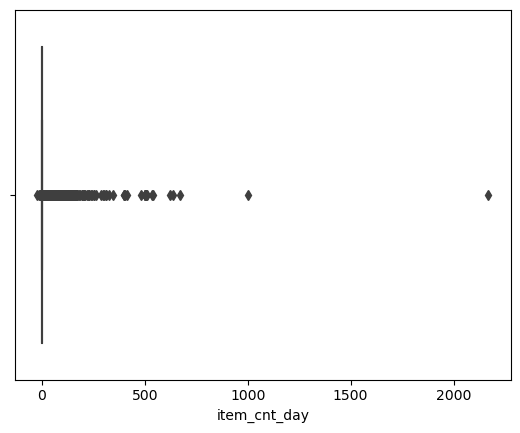

In [12]:
# 'item_cnt_day' boxplot 확인하기

sns.boxplot(train['item_cnt_day'])
plt.show()

#item_cnt_day 데이터의 분포 정도 및 이상치 확인 
#데이터가 1값에 많이 분포된것을 확인할수있습니다

c:\Users\SBAUser\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


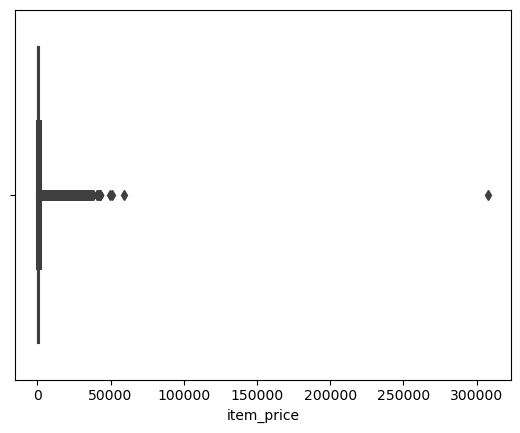

In [13]:
# 'item_price' boxplot 확인하기

sns.boxplot(train['item_price'])
plt.show()
#item_price 데이터의 분포 정도 및 이상치 확인 

In [14]:
#train 데이터의 정보를 확인
train.info()
#Dtype 확인 >> 데이터 용량 줄일 수 있음!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int64  
 2   shop_id             int64  
 3   item_id             int64  
 4   item_price          float64
 5   item_cnt_day        float64
 6   item_name           object 
 7   item_category_id    int64  
 8   item_category_name  object 
 9   shop_name           object 
dtypes: float64(2), int64(4), object(4)
memory usage: 246.4+ MB


In [15]:
#train 데이터의 평균,표준편차,최소값,최대값 등 기술통계 확인
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


최소값

item_price가 -인 것은 무엇일까?

item_cnt_day가 -인것은 무엇일까?

In [16]:
# item_price가 0보다 작은 데이터 확인하기

train[train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
2717783,15.05.2013,4,32,2973,-1.0,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,"Москва ТЦ ""Серебряный Дом"""


아이템 이름 : DmC Devil May Cry [PS3, 러시아어 자막]

아이템 카테고리 : 게임 - PS3

상점이름 : 모스크바 쇼핑 센터 "실버 하우스"

In [17]:
# item_cnt_day가 0보다 작은 것 살펴보기
train[train['item_cnt_day'] < 0]['item_cnt_day'].value_counts()


-1.0     7252
-2.0       78
-3.0       14
-5.0        4
-4.0        3
-6.0        2
-16.0       1
-22.0       1
-9.0        1
Name: item_cnt_day, dtype: int64

데이터가 굉장히 많다. 

실수로 입력된 값인지 환불에대한 정보인지 알 방법이 없다. 데이터 처리를 어떻게 해야할지 고민한다.

In [18]:
#아이템카테고리이름의 맨 앞의 단어를 잘라서 확인해보았다
train['item_category_name'].apply(lambda x : x.split()[0]).unique()

# 계략 / 게임?
# 영화
# 음악
# 현재의 / 선물?
# 부속품
# 서적
# 프로그램
# 카드
# 노름 / 콘솔게임?
# 서비스
# 강요 / 배터리
# 순수한
# 배달
# 티켓
# pc

# 큰 분류로 나눌수 있지 않을까?

array(['Кино', 'Музыка', 'Игры', 'Программы', 'Подарки', 'Книги',
       'Аксессуары', 'Игровые', 'Карты', 'Служебные', 'Элементы',
       'Билеты', 'Чистые', 'PC', 'Доставка'], dtype=object)

In [19]:
#shop_name의 맨 앞의 단어를 잘라서 확인해보았다
pd.DataFrame(train['shop_name'].apply(lambda x : x.split()[0]).value_counts())

,shop_name
Москва,996636
Якутск,188869
СПб,148535
Воронеж,144151
Химки,143480
Тюмень,125455
Уфа,96423
Красноярск,76177
Самара,75421
Чехов,69573


- 모스크바
- 야쿠츠크
- 세인트 피터스 버그
- 보로네시
- 튜멘
- 힘키
- 우파
- 크라스노야르스크
- 익과
- N.노브고로드
- 세르기예프
- 돈에 로스토프
- 수르구트
- 쿠르스크
- 체호프
- 칼루가
- 콜롬나
- 옴스크
- 카잔
- 야로슬라블
- 볼로그다
- 노보시비르스크
- 볼시스키
- 온라인 매장
- 디지털
- 톰스크
- 아디게아
- 발라시하
- 주코프스키
- 미티시치
- !야쿠츠크
- 방문

In [20]:
#시티

#Якутск(야쿠츠크) 와 !Якутск(느낌표야쿠츠크) 가 있다.
#느낌표가 포함되어 있는 단어 확인
train[train['shop_name'].apply(lambda x : x.split()[0]) == '!Якутск']

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
1363898,22.02.2013,1,1,22154,657.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"!Якутск ТЦ ""Центральный"" фран"
1363899,18.01.2013,0,1,2574,282.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,"!Якутск ТЦ ""Центральный"" фран"
1363900,09.01.2013,0,1,2574,282.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,"!Якутск ТЦ ""Центральный"" фран"
1363901,08.01.2013,0,1,2716,94.0,1.0,Darksiders (PC-DVD) (DVD-box),28,Игры PC - Дополнительные издания,"!Якутск ТЦ ""Центральный"" фран"
1363902,12.01.2013,0,1,2716,94.0,1.0,Darksiders (PC-DVD) (DVD-box),28,Игры PC - Дополнительные издания,"!Якутск ТЦ ""Центральный"" фран"
...,...,...,...,...,...,...,...,...,...,...
1379428,28.02.2013,1,0,13034,27.0,1.0,КУНГ-ФУ КРОЛИК,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
1379429,10.02.2013,1,0,13913,328.0,1.0,ЛЕТО. ОДНОКЛАСНИКИ. ЛЮБОВЬ (BD),37,Кино - Blu-Ray,"!Якутск Орджоникидзе, 56 фран"
1379430,28.02.2013,1,0,14156,27.0,2.0,Легенды русского рока. The Best (mp3) (Jewel),57,Музыка - MP3,"!Якутск Орджоникидзе, 56 фран"
1379431,28.02.2013,1,0,13799,27.0,1.0,ЛАСКОВЫЙ МАЙ / ЛЮБОВЬ В БОЛЬШОМ ГОРОДЕ,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"


In [21]:
#느낌표가 포함되어있지않은 단어 확인
train[train['shop_name'].apply(lambda x : x.split()[0]) == 'Якутск']

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
1521667,05.03.2013,2,57,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Якутск Орджоникидзе, 56"
1521668,29.04.2013,3,57,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Якутск Орджоникидзе, 56"
1521669,27.10.2013,9,57,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Якутск Орджоникидзе, 56"
1521670,20.07.2015,30,57,22154,299.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Якутск Орджоникидзе, 56"
1521671,05.09.2015,32,57,22154,299.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Якутск Орджоникидзе, 56"
...,...,...,...,...,...,...,...,...,...,...
1717494,25.10.2015,33,58,21548,399.0,1.0,ЦЕНА ЧЕЛОВЕКА,40,Кино - DVD,"Якутск ТЦ ""Центральный"""
1717495,30.10.2015,33,58,21548,399.0,1.0,ЦЕНА ЧЕЛОВЕКА,40,Кино - DVD,"Якутск ТЦ ""Центральный"""
1717496,24.10.2015,33,58,4053,2499.0,1.0,Just Dance 2016 (только для MS Kinect) [Xbox 3...,23,Игры - XBOX 360,"Якутск ТЦ ""Центральный"""
1717497,25.10.2015,33,58,4053,2499.0,1.0,Just Dance 2016 (только для MS Kinect) [Xbox 3...,23,Игры - XBOX 360,"Якутск ТЦ ""Центральный"""


Якутск 와 !Якутск 이 겹치는 것을 확인 할 수 있다. 처리를 해서 같은 것으로 묶어야 될 것 같다

# 시각화

In [29]:
#상점별 아이템별 가격추세 시각화하기 위한 함수 만듦

def check_item_price_plot(df, shop_id, item_id) :
    condition = (df['shop_id'] == shop_id) & (df['item_id'] == item_id)
    item_data = df[condition]
    
    print('shop_id :', shop_id, '\nitem_id :', item_id)
    fig, ax = plt.subplots(figsize = (20, 10))
    sns.lineplot(data = item_data, x = 'date', y = 'item_price')
    plt.xticks(rotation = 45)


shop_id : 5 
item_id : 5037


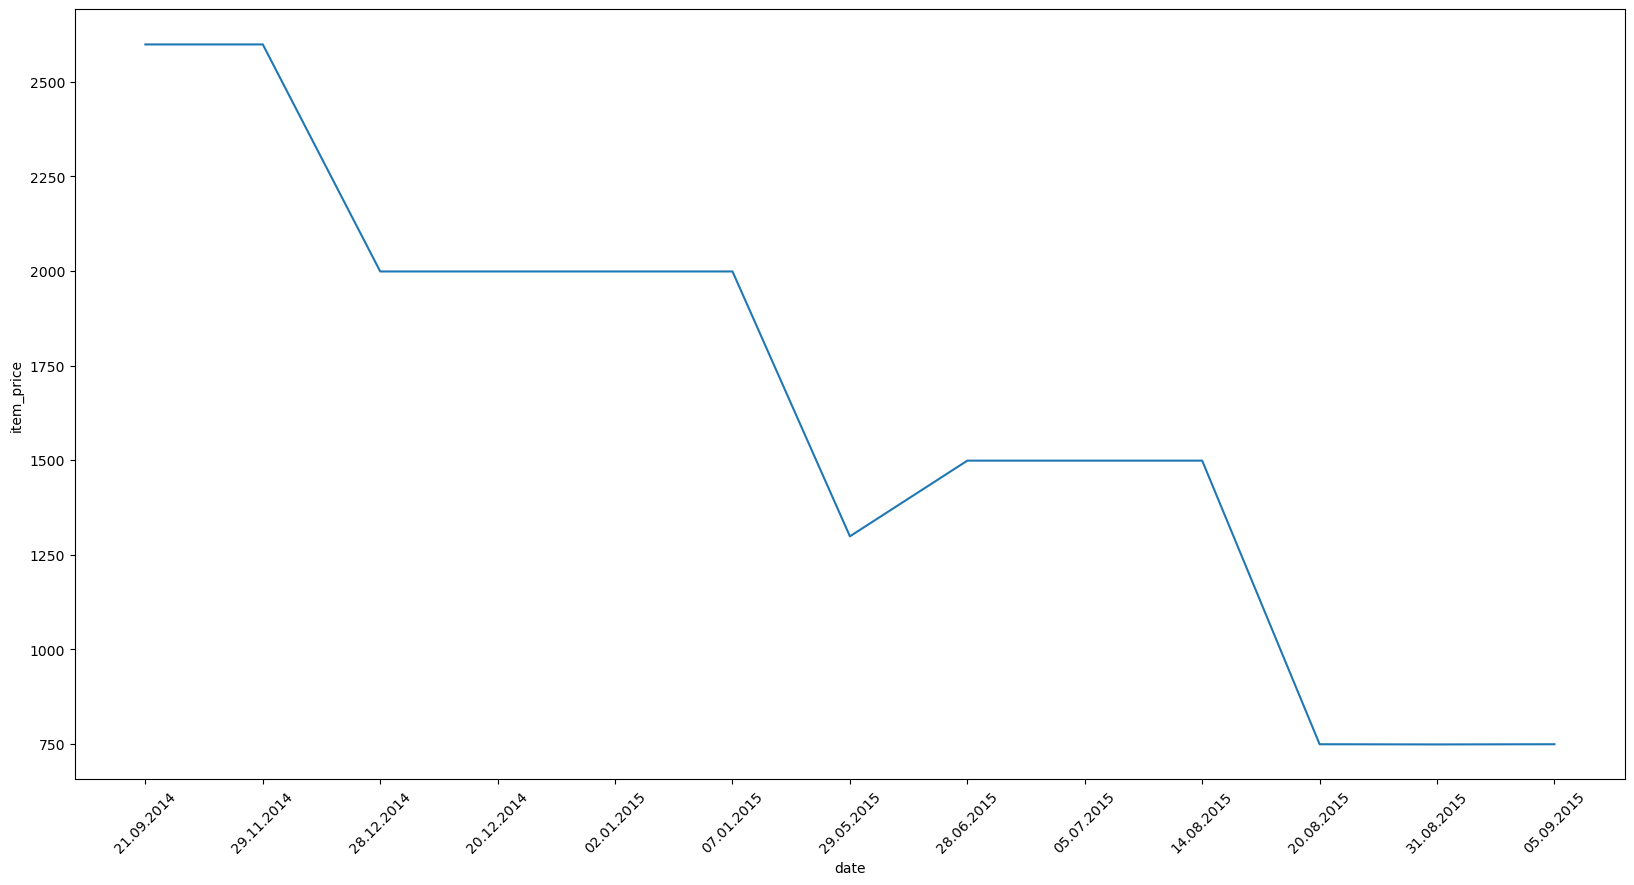

In [30]:
check_item_price_plot(train, 5, 5037)
#shop_id 가 5,item_id 가 5037 인 제품의 날짜별 가격 변동 추세를 나타내었다.

shop_id : 42 
item_id : 7808


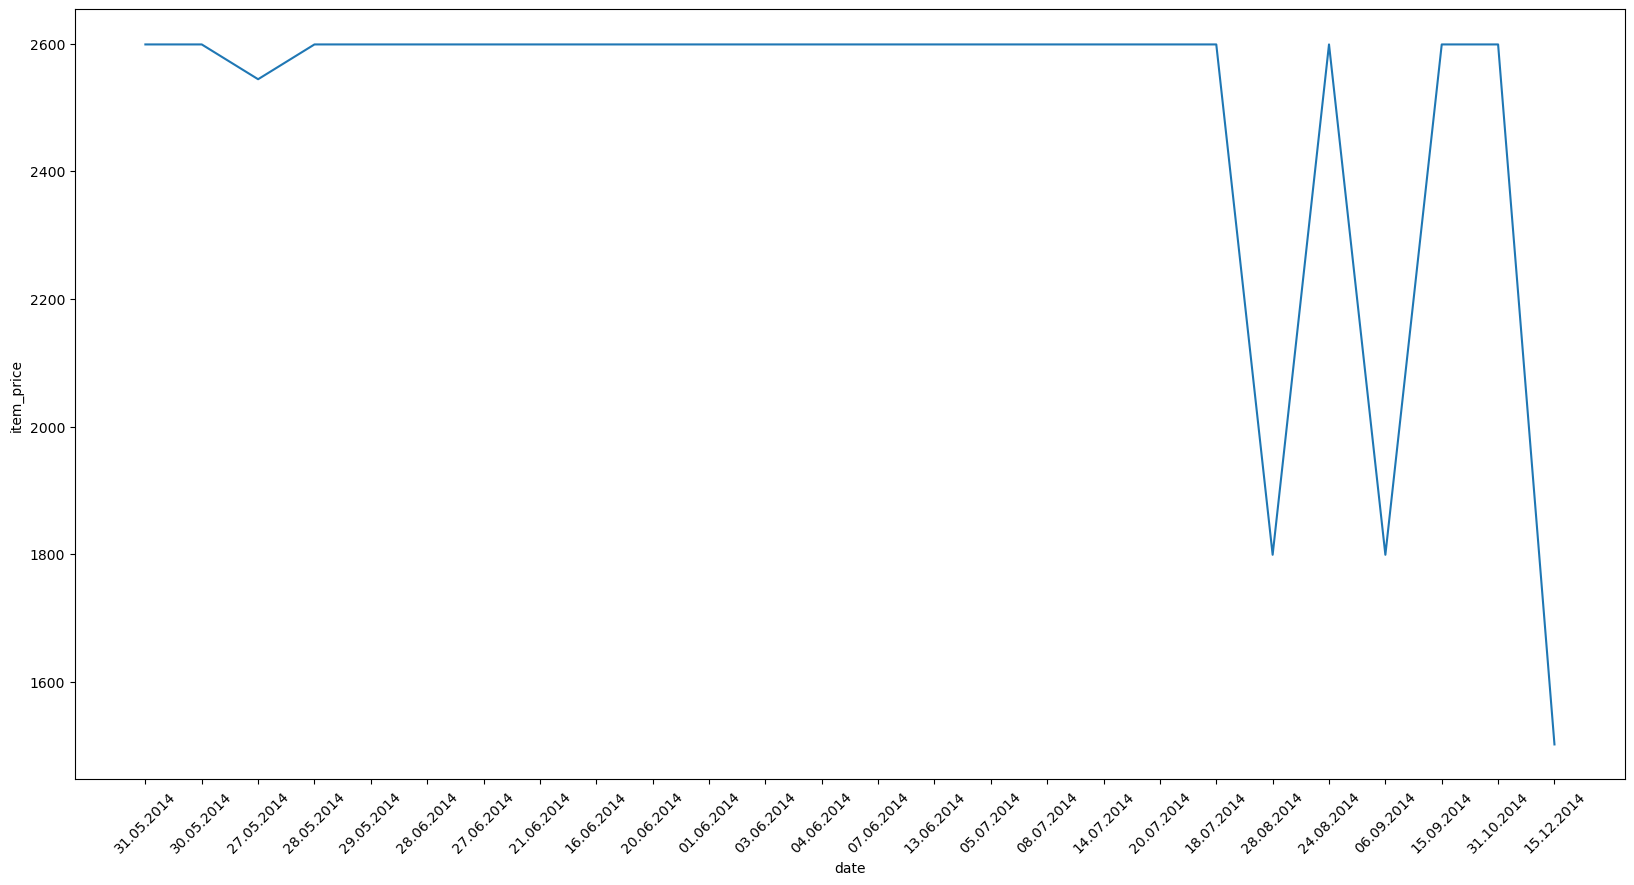

In [42]:
shop_id = random.choice(train['shop_id'])
item_id = random.choice(train['item_id'])
check_item_price_plot(train, shop_id, item_id)
#shop_id 와 item_id 를 랜덤추출 한 제품의 날짜별 가격 변동 추세를 나타내었다.

In [37]:
#상점별 카테고리별 월 평균 가격 시각화 함수 만듦
def check_itemcateg_price_plot(df, shop_id, item_category_id) :
    condition = (df['shop_id'] == shop_id) & (df['item_category_id'] == item_category_id)
    item_data = df[condition]
    
    print('shop_id :', shop_id, '\nitem_category_id :', item_category_id)
    plt.figure(figsize=(20,5))
    sns.barplot(data = item_data, x = 'date_block_num', y = 'item_price')

shop_id : 16 
item_category_id : 37


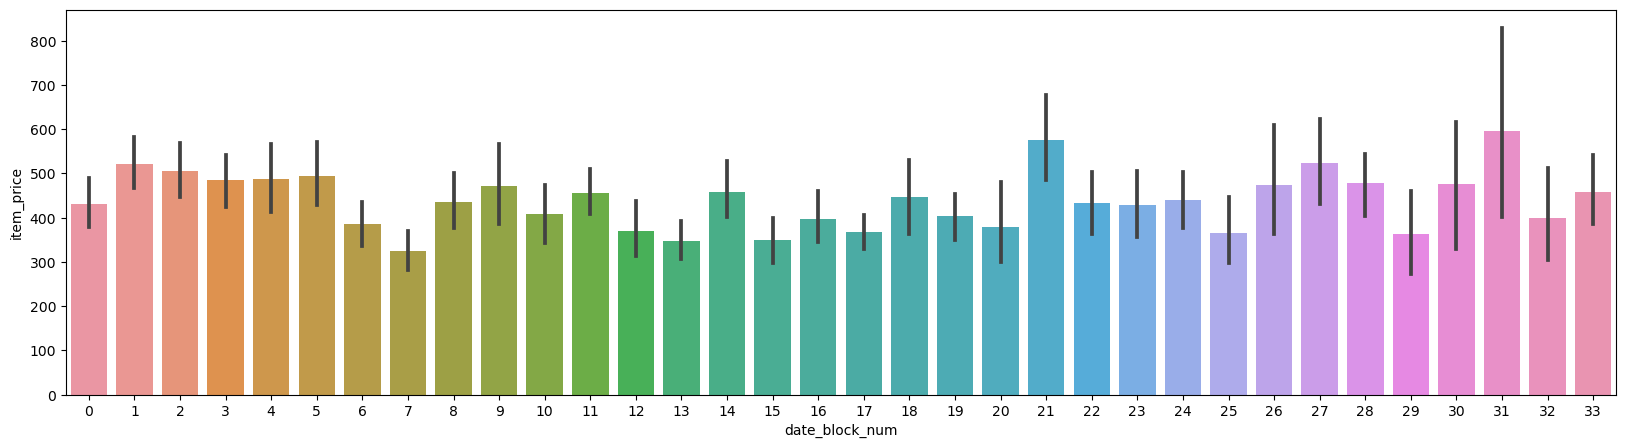

In [38]:
check_itemcateg_price_plot(train,16,37) 
#shop_id 16 이고, item_category_id 37(영화-블루레이)의 평균 및 표준편차를 바그래프로 나타냄
#검은선이 표준편차이고, 가격의 편차 큰 부분이 있으므로 그 부분을 활용한 피처정보를 추가해야할것같다

# 데이터 가공

In [ ]:
# 데이터 불러오기 

categ= pd.read_csv('./item_categories.csv')
items = pd.read_csv('./items.csv')
train = pd.read_csv('./sales_train.csv')
shops = pd.read_csv('./shops.csv')
test = pd.read_csv('./test.csv')

In [ ]:
# merge 하기 전에 shop, items, categ, train 전처리하기

In [ ]:
# 1. shop
# shop의 shop_name에서 city feature 추가함
shops['city'] = shops['shop_name'].apply(lambda x : x.split()[0])
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [ ]:
shops.city.unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

도시이름 앞에 !가 있는것을 제거해 줘야 한다

In [ ]:
# city 앞에 ! 특별 문자 삭제

shops['city'] = shops['city'].str.replace('!', '')
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [ ]:
# LabelEncoder를 통해 city들의 number를 지정해줌 > city_num

encoder = LabelEncoder()
shops['city_num'] = encoder.fit_transform(shops['city'])
shops

,shop_name,shop_id,city,city_num
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,3
6,"Воронеж (Плехановская, 13)",6,Воронеж,4
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,4
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,4
9,Выездная Торговля,9,Выездная,5


In [ ]:
# 필요 없는 feature인 city와 shop_name은 삭제해줌
shops = shops.drop(['city','shop_name'], axis=1)
shops

,shop_id,city_num
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2
5,5,3
6,6,4
7,7,4
8,8,4
9,9,5


In [ ]:
# 2. item_merge 전처리
# item_merge로 items, categ 을 merge

item_merge = pd.merge(items, categ, on = 'item_category_id')

In [ ]:
# 위에서 merge한 [item_merge]의 item_category_name 컬럼에서 type(대분류) feature 추출

item_merge['type'] = item_merge['item_category_name'].apply(lambda x : x.split()[0])
item_merge

,item_name,item_id,item_category_id,item_category_name,type
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино
...,...,...,...,...,...
22165,Элемент питания GP 15AU (LR6) - Блистер 2 шт U...,22095,83,Элементы питания,Элементы
22166,Элемент питания GP 24A (LR03) - Блистер 2 шт,22096,83,Элементы питания,Элементы
22167,Элемент питания GP 24AU (LR03) - Блистер 2 шт ...,22097,83,Элементы питания,Элементы
22168,Элемент питания КОСМОС LR03 2*BL,22098,83,Элементы питания,Элементы


In [ ]:
# item_category_name 컬럼에서 sub_type(소분류) feature 추출해보자!
# sub_type(소분류)를 추출하기 위한 two_type 컬럼 생성 : '-' 기준으로 split

item_merge['two_type'] = item_merge['item_category_name'].str.split(' - ')
item_merge

,item_name,item_id,item_category_id,item_category_name,type,two_type
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино,"[Кино, DVD]"
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино,"[Кино, DVD]"
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино,"[Кино, DVD]"
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино,"[Кино, DVD]"
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино,"[Кино, DVD]"
...,...,...,...,...,...,...
22165,Элемент питания GP 15AU (LR6) - Блистер 2 шт U...,22095,83,Элементы питания,Элементы,[Элементы питания]
22166,Элемент питания GP 24A (LR03) - Блистер 2 шт,22096,83,Элементы питания,Элементы,[Элементы питания]
22167,Элемент питания GP 24AU (LR03) - Блистер 2 шт ...,22097,83,Элементы питания,Элементы,[Элементы питания]
22168,Элемент питания КОСМОС LR03 2*BL,22098,83,Элементы питания,Элементы,[Элементы питания]


In [ ]:
# item_category_name 컬럼에서 two_type(소분류) feature 추출
# two_type 컬럼에서 sub_type(소분류) 두번째 요소 추출, 만약에 두번째 값이 없는 경우에는 첫번째 요소(대분류)로 대체해줌.

item_merge['sub_type'] = item_merge['two_type'].apply(lambda x : x[1] if len(x) > 1 else x[0])
item_merge

,item_name,item_id,item_category_id,item_category_name,type,two_type,sub_type
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино,"[Кино, DVD]",DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино,"[Кино, DVD]",DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино,"[Кино, DVD]",DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино,"[Кино, DVD]",DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино,"[Кино, DVD]",DVD
...,...,...,...,...,...,...,...
22165,Элемент питания GP 15AU (LR6) - Блистер 2 шт U...,22095,83,Элементы питания,Элементы,[Элементы питания],Элементы питания
22166,Элемент питания GP 24A (LR03) - Блистер 2 шт,22096,83,Элементы питания,Элементы,[Элементы питания],Элементы питания
22167,Элемент питания GP 24AU (LR03) - Блистер 2 шт ...,22097,83,Элементы питания,Элементы,[Элементы питания],Элементы питания
22168,Элемент питания КОСМОС LR03 2*BL,22098,83,Элементы питания,Элементы,[Элементы питания],Элементы питания


In [ ]:
# 이제 필요없는 two_type 컬럼은 삭제해준다.

item_merge = item_merge.drop('two_type', axis = 1)
item_merge

,item_name,item_id,item_category_id,item_category_name,type,sub_type
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино,DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино,DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино,DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино,DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино,DVD
...,...,...,...,...,...,...
22165,Элемент питания GP 15AU (LR6) - Блистер 2 шт U...,22095,83,Элементы питания,Элементы,Элементы питания
22166,Элемент питания GP 24A (LR03) - Блистер 2 шт,22096,83,Элементы питания,Элементы,Элементы питания
22167,Элемент питания GP 24AU (LR03) - Блистер 2 шт ...,22097,83,Элементы питания,Элементы,Элементы питания
22168,Элемент питания КОСМОС LR03 2*BL,22098,83,Элементы питания,Элементы,Элементы питания


In [ ]:
# 위에서 추출해준 type(대분류), sub_type(소분류)의 number를 인코딩해서 추출.

item_merge['type_num'] = encoder.fit_transform(item_merge['type'])
item_merge['sub_type_num'] = encoder.fit_transform(item_merge['sub_type'])
item_merge

,item_name,item_id,item_category_id,item_category_name,type,sub_type,type_num,sub_type_num
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино,DVD,7,6
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино,DVD,7,6
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино,DVD,7,6
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино,DVD,7,6
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино,DVD,7,6
...,...,...,...,...,...,...,...,...
22165,Элемент питания GP 15AU (LR6) - Блистер 2 шт U...,22095,83,Элементы питания,Элементы,Элементы питания,14,66
22166,Элемент питания GP 24A (LR03) - Блистер 2 шт,22096,83,Элементы питания,Элементы,Элементы питания,14,66
22167,Элемент питания GP 24AU (LR03) - Блистер 2 шт ...,22097,83,Элементы питания,Элементы,Элементы питания,14,66
22168,Элемент питания КОСМОС LR03 2*BL,22098,83,Элементы питания,Элементы,Элементы питания,14,66


In [ ]:
# 이제는 필요없는 'type', 'sub_type','item_name', 'item_category_name' 컬럼을 모두 drop해준다.

item_merge = item_merge.drop(['type', 'sub_type','item_name', 'item_category_name'], axis = 1)
item_merge

,item_id,item_category_id,type_num,sub_type_num
0,0,40,7,6
1,2,40,7,6
2,3,40,7,6
3,4,40,7,6
4,5,40,7,6
...,...,...,...,...
22165,22095,83,14,66
22166,22096,83,14,66
22167,22097,83,14,66
22168,22098,83,14,66


In [ ]:
# 3. train data 전처리

#결측치 확인
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [ ]:
#중복 여부 확인
sum(train.duplicated()), sum(test.duplicated()), sum(shops.duplicated()), sum(items.duplicated()), sum(categ.duplicated())

(6, 0, 0, 0, 0)

In [ ]:
#중복 데이터 상세확인
train[train.duplicated() == True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


In [ ]:
# 중복 확인 및 제거 하기

train.drop_duplicates(inplace = True)


In [ ]:
#중복 데이터 삭제 확인
sum(train.duplicated())

0

c:\Users\SBAUser\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


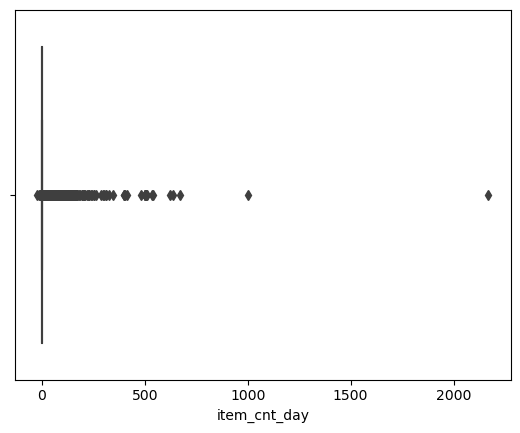

In [ ]:
# 이상치 상세 확인 1)
# 'item_cnt_day' boxplot 확인하기

sns.boxplot(train['item_cnt_day'])
plt.show()

In [ ]:
# 음수값 상세 확인

train[train['item_cnt_day'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.0,-1.0
2934462,18.10.2015,33,25,4896,6398.0,-1.0
2935263,05.10.2015,33,25,10039,249.0,-1.0
2935643,16.10.2015,33,25,7893,2990.0,-1.0


In [ ]:
len(train[train['item_cnt_day'] < 0])

7356

In [ ]:
len(train['item_cnt_day'])

2935843

In [ ]:
# 어차피 데이터의 정체를 알수없고, 0.25% 의 낮은 수치이기 때문에 삭제함

7356 / 2928487 *100

0.2511877293633197

In [ ]:
train = train.drop(train[train['item_cnt_day'] < 0].index, axis=0)

In [ ]:
# 삭제 된 것 확인

len(train[train['item_cnt_day'] < 0])

0

In [ ]:
# 양수값 중 상위 이상치 제거
# 상위 100개 값 추출

train['item_cnt_day'].nlargest(100).values

array([2169., 1000.,  669.,  637.,  624.,  539.,  533.,  512.,  508.,
        504.,  502.,  501.,  500.,  500.,  480.,  412.,  405.,  401.,
        401.,  343.,  325.,  313.,  313.,  300.,  299.,  288.,  264.,
        255.,  251.,  242.,  240.,  231.,  230.,  222.,  217.,  207.,
        205.,  205.,  200.,  195.,  194.,  187.,  179.,  171.,  171.,
        171.,  168.,  168.,  167.,  164.,  163.,  161.,  157.,  156.,
        154.,  153.,  151.,  151.,  151.,  151.,  151.,  150.,  150.,
        149.,  148.,  148.,  147.,  146.,  145.,  145.,  142.,  142.,
        140.,  139.,  139.,  138.,  138.,  135.,  134.,  134.,  133.,
        133.,  132.,  131.,  130.,  130.,  129.,  128.,  127.,  127.,
        126.,  126.,  124.,  124.,  124.,  121.,  121.,  121.,  118.,
        117.])

In [ ]:
# boxplot 을 확인했을 때 적잘한 값 >> 500
# 500 이상의 값의 갯수 : 12개 >> 굉장히 적은 수이기에 삭제하기로 결정

len(train.loc[train.item_cnt_day > 500])

12

In [ ]:
# 500이상인 것들을 삭제

train = train.drop(train[train['item_cnt_day'] >= 500].index, axis=0)

c:\Users\SBAUser\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


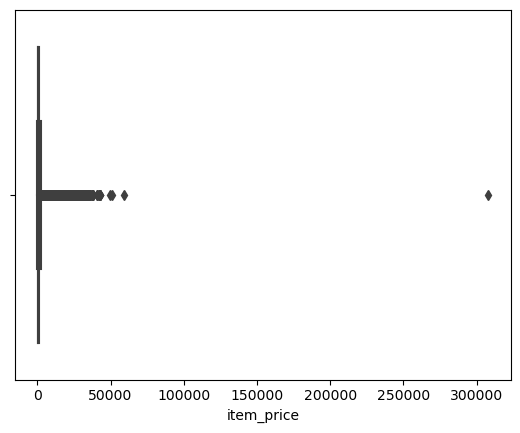

In [ ]:
# 이상치 상세 확인 2)
# 'item_price' boxplot 확인하기

sns.boxplot(train['item_price'])
plt.show()

In [ ]:
# item_price의 음수값 존재여부 확인

train[train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [ ]:
# 음수값 삭제

train = train.drop(train[train['item_price'] < 0].index, axis=0)

In [ ]:
# 양수값 중 상위 이상치 제거
# 상위 100개 값 추출

train['item_price'].nlargest(100).values

array([307980. ,  59200. ,  50999. ,  49782. ,  42990. ,  42990. ,
        42990. ,  42990. ,  42000. ,  41990. ,  41990. ,  41990. ,
        40991. ,  40900. ,  37991. ,  37991. ,  36990. ,  36990. ,
        36990. ,  36990. ,  35991. ,  35990. ,  35990. ,  35990. ,
        35490. ,  35490. ,  35490. ,  35490. ,  35490. ,  35300. ,
        35300. ,  35300. ,  35300. ,  35300. ,  35192. ,  34990. ,
        34990. ,  34990. ,  34990. ,  34990. ,  34990. ,  34990. ,
        34990. ,  34990. ,  34990. ,  34990. ,  34990. ,  34490. ,
        33990. ,  33490. ,  33490. ,  33490. ,  33490. ,  33490. ,
        33490. ,  33490. ,  32997.5,  32990. ,  32990. ,  32990. ,
        32990. ,  32990. ,  32990. ,  32990. ,  32990. ,  32990. ,
        32990. ,  32990. ,  32990. ,  32990. ,  32990. ,  32990. ,
        32990. ,  32990. ,  32990. ,  32990. ,  32990. ,  32990. ,
        32990. ,  32990. ,  32990. ,  32990. ,  32990. ,  32990. ,
        32990. ,  32990. ,  32990. ,  32990. ,  32990. ,  3299

In [ ]:
# boxplot 을 확인했을 때 적잘한 값 >> 50000
# 50000 이상의 값의 갯수 : 3개 >> 굉장히 적은 수이기에 삭제하기로 결정

len(train.loc[train.item_price > 50000])

3

In [ ]:
# 50000 것들을 삭제

train = train.drop(train[train['item_price'] >= 50000].index, axis=0)

In [ ]:
# date 컬럼을 통해 연도, 월, 일 feature 생성하기
# series >> datetime 형태로 바꾸기

print(type(train['date'].info()))

<class 'pandas.core.series.Series'>
Int64Index: 2928469 entries, 0 to 2935848
Series name: date
Non-Null Count    Dtype 
--------------    ----- 
2928469 non-null  object
dtypes: object(1)
memory usage: 44.7+ MB
<class 'NoneType'>


In [ ]:
train['date'] = pd.to_datetime(train['date'], dayfirst=True)
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0


In [ ]:
# 연도, 월, 연도월 feature 생성하기

train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['year_month'] = train['date'].dt.strftime("%Y-%m")

In [ ]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,year_month
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2013-01
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,2013-01
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,2013-01
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,2013-01
5,2013-01-10,0,25,2564,349.00,1.0,2013,1,2013-01


# 데이터 틀 만들기

In [ ]:
# 저번달에는 안 팔렸고 이번달에는 팔렸던 것들이 있습니다.
# 저번달에는 안 팔린것은 아예 표시를 해주지 않았습니다.
# 그렇기에 그러한 부분들을 0으로 넣어주어야 하는데 
# 그렇게 해줄려면 새로운 matrix / 즉 새로운 데이터프레임을 만들어야 할 것 같습니다.

In [ ]:
# itertools.product 함수를 사용해서 새로운 matrix / 새로운 데이터프레임 만들기

In [ ]:
#빈 리스트
new_matrix = []

#컬럼 명.
m_cols = ['date_block_num', 'shop_id', 'item_id']

#각 0달에서 33달까지 포문이 돕니다.
for i in range(34):
    
    #원본에서 각 달이 해당 i에 같은 경우만 가져옵니다.
    month_num = train[train['date_block_num'] == i]
    
    #위에서 만들어준 빈 리스트에 샵과 아이템 데카르트 곱한 것을 넘파이 리스트로 만들어서 추가 합니다.
    new_matrix.append(np.array(list(itertools.product([i],month_num['shop_id'].unique(),month_num['item_id'].unique()))))

#뉴 메트릭스는 리스트들입니다. 이를 새로로 합쳐주기 위해서 vstack 함수를 씁니다.
new_matrix = pd.DataFrame(np.vstack(new_matrix), columns=m_cols)
new_matrix.sort_values(m_cols, inplace=True)
new_matrix

#[0,0,0]  이거를 데카르트 제곱 후 리스트에 담고 [[0,0,0],[0,0,0],[0,0,0],...] Array로 만든다. Array[[0,0,0],[0,0,0],[0,0,0],...]] 
#array 배열 객체를 new_matrix1 리스트에 담는다 [[[0,0,0],[0,0,0],[0,0,0],...]],[[0,0,0],[0,0,0],[0,0,0],...]],[[0,0,0],[0,0,0],[0,0,0],...]]]
#이 배열 객체를 vstack 라는 함수 : 배열을 수직방향으로 쌓아서 더 큰배열을 생성하는 함수로 튜플로 묶어서 전달
#마지막으로 데이터 프레임으로 변환하여 m_cols 기준으로 나열(오름차순)

,date_block_num,shop_id,item_id
139168,0,0,19
141406,0,0,27
144881,0,0,28
142572,0,0,29
138861,0,0,32
...,...,...,...
10739498,33,59,22162
10739688,33,59,22163
10740354,33,59,22164
10741880,33,59,22166


In [ ]:
# 월별 샵별 아이템별로 판매 개수를 합쳐서 데이터프레임화
# 일일 판매를 달 판매로 바꾼다.
item_cnt = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum'})

In [ ]:
#데이터 프레임화 시킨다.

item_cnt.reset_index(inplace = True)

In [ ]:
item_cnt.head()

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [ ]:
# 칼럼 이름 바꾸어주기

item_cnt.rename(columns={'item_cnt_day' : 'item_cnt_month'},inplace=True)

In [ ]:
item_cnt

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1608216,33,59,22087,6.0
1608217,33,59,22088,2.0
1608218,33,59,22091,1.0
1608219,33,59,22100,1.0


In [ ]:
new_matrix.head()

,date_block_num,shop_id,item_id
139168,0,0,19
141406,0,0,27
144881,0,0,28
142572,0,0,29
138861,0,0,32


In [ ]:
# 위에서 만들었던 틀에다가 우리의 원본 데이터를 장착한다.

new_matrix = pd.merge(new_matrix,item_cnt, how='left')

new_matrix

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,NaN
1,0,0,27,NaN
2,0,0,28,NaN
3,0,0,29,NaN
4,0,0,32,6.0
...,...,...,...,...
10884455,33,59,22162,NaN
10884456,33,59,22163,NaN
10884457,33,59,22164,NaN
10884458,33,59,22166,NaN


In [ ]:
len(new_matrix['item_cnt_month'])

10884460

In [ ]:
len(new_matrix[new_matrix['item_cnt_month'] >= 30])

6505

In [ ]:
len(new_matrix[new_matrix['item_cnt_month'] < 0])

0

In [ ]:
len(new_matrix[new_matrix['item_cnt_month'] >= 30])/len(new_matrix['item_cnt_month'])*100
# 전체 데이터에 0.05퍼센트를 차지하므로 이상치를 바꿔주겠습니다.

0.05976410405293418

In [ ]:
# clip 을 사용해서 범위 제한하기

new_matrix['item_cnt_month'] = new_matrix['item_cnt_month'].fillna(0).clip(0, 30).astype(np.float16)

In [ ]:
new_matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0


In [ ]:
# 이렇게 만든 데이터프레임에 test를 추가하자.
# 그래야하만 이후에도 속성 정보를 추가할 때 test에도 동시에 추가될 수 있다.


In [ ]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [ ]:
# 테스트에 달을 34달로 지정해준다.

test['date_block_num'] = 34
test

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34
...,...,...,...,...
214195,214195,45,18454,34
214196,214196,45,16188,34
214197,214197,45,15757,34
214198,214198,45,19648,34


In [ ]:
#이후 원래 데이터프레임에 컨켓으로 아래에서 합친다.

new_matrix = pd.concat([new_matrix, test], ignore_index=True)
# ignore_index=Ture : 인덱스 예쁘게 정렬해주기
new_matrix.fillna(0, inplace=True)
new_matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID
0,0,0,19,0.0,0.0
1,0,0,27,0.0,0.0
2,0,0,28,0.0,0.0
3,0,0,29,0.0,0.0
4,0,0,32,6.0,0.0


In [ ]:
#바로 추가할 수 있는 특성정보는 추가한다.

In [ ]:
#shops에 존재하는 도시.
new_matrix = pd.merge(new_matrix, shops, how='left')
new_matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_num
0,0,0,19,0.0,0.0,29
1,0,0,27,0.0,0.0,29
2,0,0,28,0.0,0.0,29
3,0,0,29,0.0,0.0,29
4,0,0,32,6.0,0.0,29


In [ ]:
#item_merge에 존재하는 카테고리와 타입과 부타입.
new_matrix = pd.merge(new_matrix, item_merge, how='left')
new_matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_num,item_category_id,type_num,sub_type_num
0,0,0,19,0.0,0.0,29,40,7,6
1,0,0,27,0.0,0.0,29,19,5,12
2,0,0,28,0.0,0.0,29,30,5,57
3,0,0,29,0.0,0.0,29,23,5,18
4,0,0,32,6.0,0.0,29,40,7,6
...,...,...,...,...,...,...,...,...,...
11098655,34,45,18454,0.0,214195.0,20,55,9,4
11098656,34,45,16188,0.0,214196.0,20,64,10,44
11098657,34,45,15757,0.0,214197.0,20,55,9,4
11098658,34,45,19648,0.0,214198.0,20,40,7,6


In [ ]:
# 새로운 데이터프레임을 만들었으므로 저장을 해준다!
# new_matrix.to_csv('./final/new_matrix.csv', index = False)

In [ ]:
matrix_practice = new_matrix.copy()
matrix_practice

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_num,item_category_id,type_num,sub_type_num
0,0,0,19,0.0,0.0,29,40,7,6
1,0,0,27,0.0,0.0,29,19,5,12
2,0,0,28,0.0,0.0,29,30,5,57
3,0,0,29,0.0,0.0,29,23,5,18
4,0,0,32,6.0,0.0,29,40,7,6
...,...,...,...,...,...,...,...,...,...
11098655,34,45,18454,0.0,214195.0,20,55,9,4
11098656,34,45,16188,0.0,214196.0,20,64,10,44
11098657,34,45,15757,0.0,214197.0,20,55,9,4
11098658,34,45,19648,0.0,214198.0,20,40,7,6


# lag 데이터 만들기

In [ ]:
# lag 데이터란 과거 데이터 또는 미래 데이터 즉 시차를 주는 데이터를 의미하는데 
# 이번에는 lag 데이터에서도 과거 데이터를 이용해 추세를 학습시켜 상품 판매량을 구하는 것이 목적입니다.

In [ ]:
# lag_data를 만들기 위한 함수 정의
def lag_feature(made_matrix, lags, col): # 매개변수들을 지정을 해줍니다.
    lag_make = made_matrix[['date_block_num','shop_id','item_id',col]] # lag_make 에 값을 저장해줍니다.
    for i in lags: # lags 값들로 for 문이 돌아갑니다.
        shift_data = lag_make.copy() # 초기화를 위해 copy를 해줍니다. 변한 데이터를 쓰지 않기 위해서
        shift_data.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)] # 컬럼을 업데이트 해줍니다.
        shift_data['date_block_num'] += i # date_block_num 을 i 만큼 더해줍니다.
        made_matrix = pd.merge(made_matrix, shift_data, on=['date_block_num','shop_id','item_id'], how='left') 
        # date_block_num 을 i 만큼 더한 shift_data(matrix)를 made_matrix(매개변수로 들어가는 값와 merge 시킵니다.
    return made_matrix # made_matrix 를 반환합니다.

In [ ]:
# 예시 / df = lag_feature(new_matrix, [1,2,3,6,12], 'item_cnt_month')

In [ ]:
# 1,2,3,6,12개월을 기준으로 lag data(과거)를 만들어주기 / (item_cnt_month) 기준
# 1개월은 각 개월마다의 추세를 알기 위해서 2개월은 예를 들어 1월에는 하락세였는데 2월에는 상승세로 올라갈 수도 있어서 2개월을 봐줘야하고
# 3개월은 분기마다의 추세를 알기 위해서 6개월은 반기마다의 추세를 알기 위해 12개월은 1년마다의 추세를 알기 위해서 각각 정해서 넣어줬습니다.
# 이동 평균선이란 개념을 사용했습니다. 
# 참고자료 : https://www.youtube.com/watch?v=u_rVNwv9MoA&t=279s

df = lag_feature(new_matrix, [1,2,3,6,12], 'item_cnt_month')

In [ ]:
df

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_num,item_category_id,type_num,sub_type_num,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,0,19,0.0,0.0,29,40,7,6,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,0.0,29,19,5,12,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,0.0,29,30,5,57,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,0.0,29,23,5,18,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,0.0,29,40,7,6,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098655,34,45,18454,0.0,214195.0,20,55,9,4,1.0,0.0,0.0,0.0,NaN
11098656,34,45,16188,0.0,214196.0,20,64,10,44,0.0,0.0,NaN,NaN,NaN
11098657,34,45,15757,0.0,214197.0,20,55,9,4,0.0,0.0,0.0,0.0,0.0
11098658,34,45,19648,0.0,214198.0,20,40,7,6,0.0,0.0,0.0,0.0,NaN


In [ ]:
# 월별 평균 판매량 추가
# 월별로 판매량의 평균을 구해보았습니다.
# 판매량을 예측해야하기 때문에 평균 판매량을 
# 알면 그 달에 평균적으로 몇 개를 팔렸는지에 대한 정보를 알 수 있기 때문에 넣어주었습니다.

item_cnt_mean = new_matrix.groupby(['date_block_num']).agg({'item_cnt_month' : ['mean']})

In [ ]:
item_cnt_mean.columns = ['item_cnt_mean']
item_cnt_mean.reset_index(inplace = True)

In [ ]:
item_cnt_mean.head()

,date_block_num,item_cnt_mean
0,0,0.354980
1,1,0.333008
2,2,0.367432
3,3,0.287354
4,4,0.270996


In [ ]:
# 월별 평균 판매량 추가해주기

df = pd.merge(df, item_cnt_mean, on=['date_block_num'], how='left')
df

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_num,item_category_id,type_num,sub_type_num,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,item_cnt_mean
0,0,0,19,0.0,0.0,29,40,7,6,NaN,NaN,NaN,NaN,NaN,0.35498
1,0,0,27,0.0,0.0,29,19,5,12,NaN,NaN,NaN,NaN,NaN,0.35498
2,0,0,28,0.0,0.0,29,30,5,57,NaN,NaN,NaN,NaN,NaN,0.35498
3,0,0,29,0.0,0.0,29,23,5,18,NaN,NaN,NaN,NaN,NaN,0.35498
4,0,0,32,6.0,0.0,29,40,7,6,NaN,NaN,NaN,NaN,NaN,0.35498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098655,34,45,18454,0.0,214195.0,20,55,9,4,1.0,0.0,0.0,0.0,NaN,0.00000
11098656,34,45,16188,0.0,214196.0,20,64,10,44,0.0,0.0,NaN,NaN,NaN,0.00000
11098657,34,45,15757,0.0,214197.0,20,55,9,4,0.0,0.0,0.0,0.0,0.0,0.00000
11098658,34,45,19648,0.0,214198.0,20,40,7,6,0.0,0.0,0.0,0.0,NaN,0.00000


In [ ]:
# 1,2,3,6,12개월마다 과거 평균 판매량 추가 / lag 데이터 추가

df = lag_feature(df,[1,2,3,6,12],'item_cnt_mean')

In [ ]:
# 그달의 타겟 정보가 들어있으므로 제거해준다. 즉 우리가 타겟 데이터를 맞혀야 하는데
# 그 타겟 데이터의 직접적인 영향을 주는 정보를 쓰면 안되기 때문에 drop를 시켰습니다. (과적합 문제)

df.drop(columns=['item_cnt_mean'],inplace=True)

In [ ]:
df

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_num,item_category_id,type_num,sub_type_num,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,item_cnt_mean_lag_1,item_cnt_mean_lag_2,item_cnt_mean_lag_3,item_cnt_mean_lag_6,item_cnt_mean_lag_12
0,0,0,19,0.0,0.0,29,40,7,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,0.0,29,19,5,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,0.0,29,30,5,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,0.0,29,23,5,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,0.0,29,40,7,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098655,34,45,18454,0.0,214195.0,20,55,9,4,1.0,0.0,0.0,0.0,NaN,0.266846,0.279785,0.292725,0.268311,NaN
11098656,34,45,16188,0.0,214196.0,20,64,10,44,0.0,0.0,NaN,NaN,NaN,0.266846,0.279785,NaN,NaN,NaN
11098657,34,45,15757,0.0,214197.0,20,55,9,4,0.0,0.0,0.0,0.0,0.0,0.266846,0.279785,0.292725,0.268311,0.324707
11098658,34,45,19648,0.0,214198.0,20,40,7,6,0.0,0.0,0.0,0.0,NaN,0.266846,0.279785,0.292725,0.268311,NaN


In [ ]:
# 1,2,3,6,12개월마다 과거 item별 평균 판매 수량 추가하기  / lag 데이터 추가

item_id_mean = df.groupby(['date_block_num','item_id']).agg({'item_cnt_month' : ['mean']})
item_id_mean.columns = ['item_id_month_mean']
item_id_mean.reset_index(inplace=True)

df = pd.merge(df, item_id_mean, on=['date_block_num','item_id'], how='left')
df = lag_feature(df, [1,2,3,6,12], 'item_id_month_mean')
df.drop(['item_id_month_mean'], axis=1, inplace=True)

In [ ]:
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_num,item_category_id,type_num,sub_type_num,item_cnt_month_lag_1,...,item_cnt_mean_lag_1,item_cnt_mean_lag_2,item_cnt_mean_lag_3,item_cnt_mean_lag_6,item_cnt_mean_lag_12,item_id_month_mean_lag_1,item_id_month_mean_lag_2,item_id_month_mean_lag_3,item_id_month_mean_lag_6,item_id_month_mean_lag_12
0,0,0,19,0.0,0.0,29,40,7,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,0.0,29,19,5,12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,0.0,29,30,5,57,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,0.0,29,23,5,18,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,0.0,29,40,7,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 1,2,3,6,12개월마다 과거 상점마다의 평균 판매수량 추가하기

shop_id_mean = df.groupby(['date_block_num','shop_id']).agg({'item_cnt_month' : ['mean']})
shop_id_mean.columns = ['shop_id_month_mean']
shop_id_mean.reset_index(inplace=True)

df = pd.merge(df, shop_id_mean, on=['date_block_num','shop_id'], how='left')
df = lag_feature(df, [1,2,3,6,12], 'shop_id_month_mean')
df.drop(['shop_id_month_mean'], axis=1, inplace=True)

In [ ]:
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_num,item_category_id,type_num,sub_type_num,item_cnt_month_lag_1,...,item_id_month_mean_lag_1,item_id_month_mean_lag_2,item_id_month_mean_lag_3,item_id_month_mean_lag_6,item_id_month_mean_lag_12,shop_id_month_mean_lag_1,shop_id_month_mean_lag_2,shop_id_month_mean_lag_3,shop_id_month_mean_lag_6,shop_id_month_mean_lag_12
0,0,0,19,0.0,0.0,29,40,7,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,0.0,29,19,5,12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,0.0,29,30,5,57,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,0.0,29,23,5,18,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,0.0,29,40,7,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 1,2,3,6,12개월마다 과거 상점마다의 아이템 평균판매수량 추가하기

shop_item_id_mean = df.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_month' : ['mean']})
shop_item_id_mean.columns = ['shop_item_id_month_mean']
shop_item_id_mean.reset_index(inplace=True)

df = pd.merge(df, shop_item_id_mean, on=['date_block_num','shop_id','item_id'], how='left')
df = lag_feature(df, [1,2,3,6,12], 'shop_item_id_month_mean')
df.drop(['shop_item_id_month_mean'], axis=1, inplace=True)

In [ ]:
df

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_num,item_category_id,type_num,sub_type_num,item_cnt_month_lag_1,...,shop_id_month_mean_lag_1,shop_id_month_mean_lag_2,shop_id_month_mean_lag_3,shop_id_month_mean_lag_6,shop_id_month_mean_lag_12,shop_item_id_month_mean_lag_1,shop_item_id_month_mean_lag_2,shop_item_id_month_mean_lag_3,shop_item_id_month_mean_lag_6,shop_item_id_month_mean_lag_12
0,0,0,19,0.0,0.0,29,40,7,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,0.0,29,19,5,12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,0.0,29,30,5,57,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,0.0,29,23,5,18,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,0.0,29,40,7,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098655,34,45,18454,0.0,214195.0,20,55,9,4,1.0,...,0.129761,0.129395,0.139282,0.142334,NaN,1.0,0.0,0.0,0.0,NaN
11098656,34,45,16188,0.0,214196.0,20,64,10,44,0.0,...,0.129761,0.129395,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
11098657,34,45,15757,0.0,214197.0,20,55,9,4,0.0,...,0.129761,0.129395,0.139282,0.142334,0.185913,0.0,0.0,0.0,0.0,0.0
11098658,34,45,19648,0.0,214198.0,20,40,7,6,0.0,...,0.129761,0.129395,0.139282,0.142334,NaN,0.0,0.0,0.0,0.0,NaN


In [ ]:
# 월별 category별 과거 평균 판매 수량 추가하기 / 위에 lag 데이터들과 달리 월별로만 lag 데이터를 만들어 놓았는데 이유는 위에서 지정한 변수들은 train에 애초부터 들어가 있는 것들로 중요한 변수들이라고 생각해서 
# 월별/분기/반기/연도 별로 나누어 lag 데이터들을 만들었는데
# 저희가 새롭게 만든 변수들은 위에 변수들에 비해 중요성을 낮게 봐서 월별로만 lag 데이터를 만들었습니다.

categ_id_month_mean = df.groupby(['date_block_num','item_category_id']).agg({'item_cnt_month' : ['mean']})
categ_id_month_mean.columns = ['categ_id_month_mean']
categ_id_month_mean.reset_index(inplace=True)

df = pd.merge(df, categ_id_month_mean, on=['date_block_num','item_category_id'], how='left')
df = lag_feature(df, [1], 'categ_id_month_mean')
df.drop(['categ_id_month_mean'], axis=1, inplace=True)

In [ ]:
df

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_num,item_category_id,type_num,sub_type_num,item_cnt_month_lag_1,...,shop_id_month_mean_lag_2,shop_id_month_mean_lag_3,shop_id_month_mean_lag_6,shop_id_month_mean_lag_12,shop_item_id_month_mean_lag_1,shop_item_id_month_mean_lag_2,shop_item_id_month_mean_lag_3,shop_item_id_month_mean_lag_6,shop_item_id_month_mean_lag_12,categ_id_month_mean_lag_1
0,0,0,19,0.0,0.0,29,40,7,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,0.0,29,19,5,12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,0.0,29,30,5,57,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,0.0,29,23,5,18,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,0.0,29,40,7,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098655,34,45,18454,0.0,214195.0,20,55,9,4,1.0,...,0.129395,0.139282,0.142334,NaN,1.0,0.0,0.0,0.0,NaN,0.197388
11098656,34,45,16188,0.0,214196.0,20,64,10,44,0.0,...,0.129395,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.156616
11098657,34,45,15757,0.0,214197.0,20,55,9,4,0.0,...,0.129395,0.139282,0.142334,0.185913,0.0,0.0,0.0,0.0,0.0,0.197388
11098658,34,45,19648,0.0,214198.0,20,40,7,6,0.0,...,0.129395,0.139282,0.142334,NaN,0.0,0.0,0.0,0.0,NaN,0.221802


In [ ]:
df.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'city_num', 'item_category_id', 'type_num', 'sub_type_num',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12', 'item_cnt_mean_lag_1',
       'item_cnt_mean_lag_2', 'item_cnt_mean_lag_3', 'item_cnt_mean_lag_6',
       'item_cnt_mean_lag_12', 'item_id_month_mean_lag_1',
       'item_id_month_mean_lag_2', 'item_id_month_mean_lag_3',
       'item_id_month_mean_lag_6', 'item_id_month_mean_lag_12',
       'shop_id_month_mean_lag_1', 'shop_id_month_mean_lag_2',
       'shop_id_month_mean_lag_3', 'shop_id_month_mean_lag_6',
       'shop_id_month_mean_lag_12', 'shop_item_id_month_mean_lag_1',
       'shop_item_id_month_mean_lag_2', 'shop_item_id_month_mean_lag_3',
       'shop_item_id_month_mean_lag_6', 'shop_item_id_month_mean_lag_12',
       'categ_id_month_mean_lag_1'],
      dtype='object')

In [ ]:
final_matrix = df.copy()

In [ ]:
# 메모리 사용을 줄이기 위해 각 컬럼의 타입을 바꾸어주었습니다.

final_matrix[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12', 'item_cnt_mean_lag_1',
       'item_cnt_mean_lag_2', 'item_cnt_mean_lag_3', 'item_cnt_mean_lag_6',
       'item_cnt_mean_lag_12', 'item_id_month_mean_lag_1',
       'item_id_month_mean_lag_2', 'item_id_month_mean_lag_3',
       'item_id_month_mean_lag_6', 'item_id_month_mean_lag_12',
       'shop_id_month_mean_lag_1', 'shop_id_month_mean_lag_2',
       'shop_id_month_mean_lag_3', 'shop_id_month_mean_lag_6',
       'shop_id_month_mean_lag_12', 'shop_item_id_month_mean_lag_1',
       'shop_item_id_month_mean_lag_2', 'shop_item_id_month_mean_lag_3',
       'shop_item_id_month_mean_lag_6', 'shop_item_id_month_mean_lag_12',
       'categ_id_month_mean_lag_1']] = final_matrix[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12', 'item_cnt_mean_lag_1',
       'item_cnt_mean_lag_2', 'item_cnt_mean_lag_3', 'item_cnt_mean_lag_6',
       'item_cnt_mean_lag_12', 'item_id_month_mean_lag_1',
       'item_id_month_mean_lag_2', 'item_id_month_mean_lag_3',
       'item_id_month_mean_lag_6', 'item_id_month_mean_lag_12',
       'shop_id_month_mean_lag_1', 'shop_id_month_mean_lag_2',
       'shop_id_month_mean_lag_3', 'shop_id_month_mean_lag_6',
       'shop_id_month_mean_lag_12', 'shop_item_id_month_mean_lag_1',
       'shop_item_id_month_mean_lag_2', 'shop_item_id_month_mean_lag_3',
       'shop_item_id_month_mean_lag_6', 'shop_item_id_month_mean_lag_12',
       'categ_id_month_mean_lag_1']].astype('float16')

In [ ]:
final_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11098660 entries, 0 to 11098659
Data columns (total 35 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   date_block_num                  int64  
 1   shop_id                         int64  
 2   item_id                         int64  
 3   item_cnt_month                  float16
 4   ID                              float64
 5   city_num                        int32  
 6   item_category_id                int64  
 7   type_num                        int32  
 8   sub_type_num                    int32  
 9   item_cnt_month_lag_1            float16
 10  item_cnt_month_lag_2            float16
 11  item_cnt_month_lag_3            float16
 12  item_cnt_month_lag_6            float16
 13  item_cnt_month_lag_12           float16
 14  item_cnt_mean_lag_1             float16
 15  item_cnt_mean_lag_2             float16
 16  item_cnt_mean_lag_3             float16
 17  item_cnt_mean_lag_6      

In [ ]:
# 메모리 용량을 줄이기 위해 타입 바꾸어주기 

final_matrix[['date_block_num', 'shop_id']] = final_matrix[['date_block_num', 'shop_id']].astype('int8')

In [ ]:
# 메모리 용량을 줄이기 위해 타입 바꾸어주기 

final_matrix[['item_id']] = final_matrix[['item_id']].astype('int16')

In [ ]:
# 메모리 용량을 줄이기 위해 타입 바꾸어주기 

final_matrix[['city_num', 'item_category_id', 'type_num', 'sub_type_num']] = final_matrix[['city_num', 'item_category_id', 'type_num', 'sub_type_num']].astype('int8')

In [ ]:
final_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11098660 entries, 0 to 11098659
Data columns (total 35 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   date_block_num                  int8   
 1   shop_id                         int8   
 2   item_id                         int16  
 3   item_cnt_month                  float16
 4   ID                              float64
 5   city_num                        int8   
 6   item_category_id                int8   
 7   type_num                        int8   
 8   sub_type_num                    int8   
 9   item_cnt_month_lag_1            float16
 10  item_cnt_month_lag_2            float16
 11  item_cnt_month_lag_3            float16
 12  item_cnt_month_lag_6            float16
 13  item_cnt_month_lag_12           float16
 14  item_cnt_mean_lag_1             float16
 15  item_cnt_mean_lag_2             float16
 16  item_cnt_mean_lag_3             float16
 17  item_cnt_mean_lag_6      

In [ ]:
# 메모리 용량을 줄이기 위해 타입 바꾸어주기

final_matrix[['item_cnt_month']] = final_matrix[['item_cnt_month']].astype('float16')

In [ ]:
# 새롭게 만든 변수들로 여러가지 lag 데이터들 추가하기
# 월별 shop별, category별 평균 판매 수량 lag 추가하기

shop_categ_id_month_mean = final_matrix.groupby(['date_block_num','shop_id','item_category_id']).agg({'item_cnt_month' : ['mean']})
shop_categ_id_month_mean.columns = ['shop_categ_id_month_mean']
shop_categ_id_month_mean.reset_index(inplace=True)

final_matrix = pd.merge(final_matrix, shop_categ_id_month_mean, on=['date_block_num','shop_id','item_category_id'], how='left')
final_matrix['shop_categ_id_month_mean'] = final_matrix['shop_categ_id_month_mean'].astype('float16')
final_matrix = lag_feature(final_matrix, [1], 'shop_categ_id_month_mean')
final_matrix.drop(['shop_categ_id_month_mean'], axis=1, inplace=True)

In [ ]:
final_matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_num,item_category_id,type_num,sub_type_num,item_cnt_month_lag_1,...,shop_id_month_mean_lag_3,shop_id_month_mean_lag_6,shop_id_month_mean_lag_12,shop_item_id_month_mean_lag_1,shop_item_id_month_mean_lag_2,shop_item_id_month_mean_lag_3,shop_item_id_month_mean_lag_6,shop_item_id_month_mean_lag_12,categ_id_month_mean_lag_1,shop_categ_id_month_mean_lag_1
0,0,0,19,0.0,0.0,29,40,7,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,0.0,29,19,5,12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,0.0,29,30,5,57,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,0.0,29,23,5,18,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,0.0,29,40,7,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098655,34,45,18454,0.0,214195.0,20,55,9,4,1.0,...,0.139282,0.142334,NaN,1.0,0.0,0.0,0.0,NaN,0.197388,0.126831
11098656,34,45,16188,0.0,214196.0,20,64,10,44,0.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.156616,0.094482
11098657,34,45,15757,0.0,214197.0,20,55,9,4,0.0,...,0.139282,0.142334,0.185913,0.0,0.0,0.0,0.0,0.0,0.197388,0.126831
11098658,34,45,19648,0.0,214198.0,20,40,7,6,0.0,...,0.139282,0.142334,NaN,0.0,0.0,0.0,0.0,NaN,0.221802,0.083740


In [ ]:
# 월별 shop별, type_num별 과거 평균 판매 수량 lag 추가하기

shop_type_num_month_mean = final_matrix.groupby(['date_block_num','shop_id','type_num']).agg({'item_cnt_month' : ['mean']})
shop_type_num_month_mean.columns = ['shop_type_num_month_mean']
shop_type_num_month_mean.reset_index(inplace=True)

final_matrix = pd.merge(final_matrix, shop_type_num_month_mean, on=['date_block_num','shop_id','type_num'], how='left')
final_matrix['shop_type_num_month_mean'] = final_matrix['shop_type_num_month_mean'].astype('float16')
final_matrix = lag_feature(final_matrix, [1], 'shop_type_num_month_mean')
final_matrix.drop(['shop_type_num_month_mean'], axis=1, inplace=True)

In [ ]:
# 월별 city_num별 과거 평균 판매 수량 추가하기

city_num_month_mean = final_matrix.groupby(['date_block_num','city_num']).agg({'item_cnt_month' : ['mean']})
city_num_month_mean.columns = ['city_num_month_mean']
city_num_month_mean.reset_index(inplace=True)

final_matrix = pd.merge(final_matrix, city_num_month_mean, on=['date_block_num','city_num'], how='left')
final_matrix['city_num_month_mean'] = final_matrix['city_num_month_mean'].astype('float16')
final_matrix = lag_feature(final_matrix, [1], 'city_num_month_mean')
final_matrix.drop(['city_num_month_mean'], axis=1, inplace=True)

In [ ]:
# 월별 item별, city_num별 과거 평균 판매 수량 추가하기

item_city_num_month_mean = final_matrix.groupby(['date_block_num','item_id','city_num']).agg({'item_cnt_month' : ['mean']})
item_city_num_month_mean.columns = ['item_city_num_month_mean']
item_city_num_month_mean.reset_index(inplace=True)

final_matrix = pd.merge(final_matrix, item_city_num_month_mean, on=['date_block_num','item_id','city_num'], how='left')
final_matrix['item_city_num_month_mean'] = final_matrix['item_city_num_month_mean'].astype('float16')
final_matrix = lag_feature(final_matrix, [1], 'item_city_num_month_mean')
final_matrix.drop(['item_city_num_month_mean'], axis=1, inplace=True)

In [ ]:
# 월별 type_num별 과거 평균 판매 수량 추가하기

type_num_month_mean = final_matrix.groupby(['date_block_num','type_num']).agg({'item_cnt_month' : ['mean']})
type_num_month_mean.columns = ['type_num_month_mean']
type_num_month_mean.reset_index(inplace=True)

final_matrix = pd.merge(final_matrix, type_num_month_mean, on=['date_block_num','type_num'], how='left')
final_matrix['type_num_month_mean'] = final_matrix['type_num_month_mean'].astype('float16')
final_matrix = lag_feature(final_matrix, [1], 'type_num_month_mean')
final_matrix.drop(['type_num_month_mean'], axis=1, inplace=True)

In [ ]:
# item_id별 평균 가격 추가
# 월별 아이템 수량을 예측하는데 있어 가격이 연관성이 있다고 판단해서 가격 변수를 추가해주는데 각 아이템들 마다 가격이 세일로 인해서 가격 차이가 나서 평균값으로 해서 추가를 해주었습니다.

item_id_mean_price = train.groupby(['item_id']).agg({'item_price': ['mean']})
item_id_mean_price.columns = ['item_id_mean_price']
item_id_mean_price.reset_index(inplace=True)
final_matrix = pd.merge(final_matrix, item_id_mean_price, on=['item_id'], how='left')
final_matrix['item_id_mean_price'] = final_matrix['item_id_mean_price'].astype(np.float16)

In [ ]:
final_matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_num,item_category_id,type_num,sub_type_num,item_cnt_month_lag_1,...,shop_item_id_month_mean_lag_3,shop_item_id_month_mean_lag_6,shop_item_id_month_mean_lag_12,categ_id_month_mean_lag_1,shop_categ_id_month_mean_lag_1,shop_type_num_month_mean_lag_1,city_num_month_mean_lag_1,item_city_num_month_mean_lag_1,type_num_month_mean_lag_1,item_id_mean_price
0,0,0,19,0.0,0.0,29,40,7,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.000
1,0,0,27,0.0,0.0,29,19,5,12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1461.000
2,0,0,28,0.0,0.0,29,30,5,57,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,309.000
3,0,0,29,0.0,0.0,29,23,5,18,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1702.000
4,0,0,32,6.0,0.0,29,40,7,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249.750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098655,34,45,18454,0.0,214195.0,20,55,9,4,1.0,...,0.0,0.0,NaN,0.197388,0.126831,0.089294,0.136963,0.5,0.147339,188.625
11098656,34,45,16188,0.0,214196.0,20,64,10,44,0.0,...,NaN,NaN,NaN,0.156616,0.094482,0.113098,0.136963,0.0,0.248535,1257.000
11098657,34,45,15757,0.0,214197.0,20,55,9,4,0.0,...,0.0,0.0,0.0,0.197388,0.126831,0.089294,0.136963,0.0,0.147339,198.125
11098658,34,45,19648,0.0,214198.0,20,40,7,6,0.0,...,0.0,0.0,NaN,0.221802,0.083740,0.097046,0.136963,0.0,0.225830,98.125


In [ ]:
# 월별 아이템별 과거 평균 가격 추가 / 아이템별, 월별로 평균 가격을 놓고 월별/분기/반기/연도별로 lag 데이터를 만들어 그 lag 데이터의 가격과 판매수량을 연관시켜 학습시키도록 유도했습니다.
# 예시) 어떠한 가격일때 몇개가 팔렸다.

month_item_id_mean_price = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
month_item_id_mean_price.columns = ['month_item_id_mean_price']
month_item_id_mean_price.reset_index(inplace=True)

final_matrix = pd.merge(final_matrix, month_item_id_mean_price, how='left')
final_matrix = lag_feature(final_matrix, [1,2,3,6,12], 'month_item_id_mean_price')
final_matrix['month_item_id_mean_price'] = final_matrix['month_item_id_mean_price'].astype(np.float16)

In [ ]:
final_matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_num,item_category_id,type_num,sub_type_num,item_cnt_month_lag_1,...,city_num_month_mean_lag_1,item_city_num_month_mean_lag_1,type_num_month_mean_lag_1,item_id_mean_price,month_item_id_mean_price,month_item_id_mean_price_lag_1,month_item_id_mean_price_lag_2,month_item_id_mean_price_lag_3,month_item_id_mean_price_lag_6,month_item_id_mean_price_lag_12
0,0,0,19,0.0,0.0,29,40,7,6,NaN,...,NaN,NaN,NaN,28.000,28.0,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,0.0,29,19,5,12,NaN,...,NaN,NaN,NaN,1461.000,2324.0,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,0.0,29,30,5,57,NaN,...,NaN,NaN,NaN,309.000,549.0,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,0.0,29,23,5,18,NaN,...,NaN,NaN,NaN,1702.000,2378.0,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,0.0,29,40,7,6,NaN,...,NaN,NaN,NaN,249.750,338.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098655,34,45,18454,0.0,214195.0,20,55,9,4,1.0,...,0.136963,0.5,0.147339,188.625,NaN,99.0,99.000000,99.000000,199.000000,NaN
11098656,34,45,16188,0.0,214196.0,20,64,10,44,0.0,...,0.136963,0.0,0.248535,1257.000,NaN,1359.0,1222.966667,NaN,NaN,NaN
11098657,34,45,15757,0.0,214197.0,20,55,9,4,0.0,...,0.136963,0.0,0.147339,198.125,NaN,229.0,229.000000,229.000000,208.090909,199.0
11098658,34,45,19648,0.0,214198.0,20,40,7,6,0.0,...,0.136963,0.0,0.225830,98.125,NaN,89.1,99.000000,94.857143,99.000000,NaN


In [ ]:
# item_id별 평균가격으로는 부족할거 같아 표준 가격도 추가하여 넣어주었습니다.

item_id_std_price = train.groupby(['item_id']).agg({'item_price': ['std']})
item_id_std_price.columns = ['item_id_std_price']
item_id_std_price.reset_index(inplace=True)
final_matrix = pd.merge(final_matrix, item_id_std_price, on=['item_id'], how='left')
final_matrix['item_id_std_price'] = final_matrix['item_id_std_price'].astype(np.float16)

# 최종 데이터 프레임 만들기

In [ ]:
# 여기서부터는 위에서 만든 파생변수들을 최종적으로 합쳐 모델링에 들어갈 데이터 프레임을 만들어주는 작업을 합니다.
# 먼저 train을 불러옵니다. 
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,year_month
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2013-01
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,2013-01
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,2013-01
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,2013-01
5,2013-01-10,0,25,2564,349.00,1.0,2013,1,2013-01
...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,2015,10,2015-10
2935845,2015-10-09,33,25,7460,299.00,1.0,2015,10,2015-10
2935846,2015-10-14,33,25,7459,349.00,1.0,2015,10,2015-10
2935847,2015-10-22,33,25,7440,299.00,1.0,2015,10,2015-10


In [ ]:
# train에 item_category_id가 없으므로 item_merge와 merge해준다

train = pd.merge(train, item_merge, on = 'item_id')
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,year_month,item_category_id,type_num,sub_type_num
0,2013-01-02,0,59,22154,999.0,1.0,2013,1,2013-01,37,7,1
1,2013-01-23,0,24,22154,999.0,1.0,2013,1,2013-01,37,7,1
2,2013-01-20,0,27,22154,999.0,1.0,2013,1,2013-01,37,7,1
3,2013-01-02,0,25,22154,999.0,1.0,2013,1,2013-01,37,7,1
4,2013-01-03,0,25,22154,999.0,1.0,2013,1,2013-01,37,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2928464,2015-10-17,33,25,8428,249.0,1.0,2015,10,2015-10,40,7,6
2928465,2015-10-01,33,25,7903,12198.0,1.0,2015,10,2015-10,15,4,18
2928466,2015-10-29,33,25,7610,2890.0,1.0,2015,10,2015-10,64,10,44
2928467,2015-10-22,33,25,7635,2100.0,1.0,2015,10,2015-10,64,10,44


In [ ]:
# final_matrix에서 월별 아이템 평균 가격을 나타내었을 때 NaN 값들이 있는데 
# 그 NaN 값들은 item_category_id 를 기준으로 한 item_price의 평균값으로 대체하였습니다
# 더 넓은 범위의 기준으로 기준에 못 미치는 nan값들의 값을 채워주는 역할을 할 예정입니다.

categ_id_mean_price = train.groupby(['item_category_id']).agg({'item_price' : ['mean']})
categ_id_mean_price.columns=['categ_id_mean_price']
categ_id_mean_price.reset_index(inplace=True)
categ_id_mean_price

,item_category_id,categ_id_mean_price
0,0,87.800000
1,1,215.500000
2,2,2255.981900
3,3,2105.419083
4,4,555.057055
...,...,...
79,79,1094.625747
80,80,1245.493528
81,81,189.037783
82,82,32.481014


In [ ]:
categ_id_mean_price.isnull().sum()
# nan값 확인

item_category_id       0
categ_id_mean_price    0
dtype: int64

In [ ]:
# 또 final_matrix에서 아이템 가격의 표준편차를 나타내었을 때 NaN 값들이 있는데 
# 그 NaN 값들은 item_category_id 를 기준으로 한 item_price의 표준편차값으로 대체하였습니다
# 더 넓은 범위의 기준으로 기준에 못 미치는 nan값들의 값을 채워주는 역할을 할 예정입니다.

categ_id_std_price = train.groupby(['item_category_id']).agg({'item_price' : ['std']})
categ_id_std_price.columns = ['categ_id_std_price']
categ_id_std_price.reset_index(inplace=True)
categ_id_std_price

,item_category_id,categ_id_std_price
0,0,62.961258
1,1,95.459415
2,2,1166.823768
3,3,1435.411373
4,4,487.854104
...,...,...
79,79,830.026934
80,80,207.837052
81,81,121.669528
82,82,17.040604


In [ ]:
# 위에서 만든 데이터로 
# lag데이터들의 NaN 값들 채워주기

#카테고리별 평균가격과 표준편차를 final_matrix에 merge 시켜줍니다.
final_matrix = pd.merge(final_matrix, categ_id_mean_price, on='item_category_id', how='left')
final_matrix = pd.merge(final_matrix, categ_id_std_price, on='item_category_id', how='left')

# 먼저 lag데이터의 nan값을 카테고리별 평균 가격으로 채워줍니다.
final_matrix['month_item_id_mean_price_lag_1'] = final_matrix['month_item_id_mean_price_lag_1'].fillna(final_matrix['categ_id_mean_price'])
final_matrix['month_item_id_mean_price_lag_2'] = final_matrix['month_item_id_mean_price_lag_2'].fillna(final_matrix['categ_id_mean_price'])
final_matrix['month_item_id_mean_price_lag_3'] = final_matrix['month_item_id_mean_price_lag_3'].fillna(final_matrix['categ_id_mean_price'])
final_matrix['item_id_std_price']=final_matrix['item_id_std_price'].fillna(final_matrix['categ_id_std_price'])

# 쓰임을 다한 카테고리별 평균가격과 카테고리별 가격의 표준편차 가격은 삭제합니다. 
final_matrix.drop(columns=['categ_id_mean_price','categ_id_std_price'],inplace=True) 

In [ ]:
final_matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_num,item_category_id,type_num,sub_type_num,item_cnt_month_lag_1,...,item_city_num_month_mean_lag_1,type_num_month_mean_lag_1,item_id_mean_price,month_item_id_mean_price,month_item_id_mean_price_lag_1,month_item_id_mean_price_lag_2,month_item_id_mean_price_lag_3,month_item_id_mean_price_lag_6,month_item_id_mean_price_lag_12,item_id_std_price
0,0,0,19,0.0,0.0,29,40,7,6,NaN,...,NaN,NaN,28.000,28.0,256.342226,256.342226,256.342226,NaN,NaN,128.625000
1,0,0,27,0.0,0.0,29,19,5,12,NaN,...,NaN,NaN,1461.000,2324.0,1511.455229,1511.455229,1511.455229,NaN,NaN,610.000000
2,0,0,28,0.0,0.0,29,30,5,57,NaN,...,NaN,NaN,309.000,549.0,499.109889,499.109889,499.109889,NaN,NaN,118.500000
3,0,0,29,0.0,0.0,29,23,5,18,NaN,...,NaN,NaN,1702.000,2378.0,1478.654097,1478.654097,1478.654097,NaN,NaN,598.000000
4,0,0,32,6.0,0.0,29,40,7,6,NaN,...,NaN,NaN,249.750,338.0,256.342226,256.342226,256.342226,NaN,NaN,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098655,34,45,18454,0.0,214195.0,20,55,9,4,1.0,...,0.5,0.147339,188.625,NaN,99.000000,99.000000,99.000000,199.000000,NaN,29.921875
11098656,34,45,16188,0.0,214196.0,20,64,10,44,0.0,...,0.0,0.248535,1257.000,NaN,1359.000000,1222.966667,1028.948188,NaN,NaN,68.000000
11098657,34,45,15757,0.0,214197.0,20,55,9,4,0.0,...,0.0,0.147339,198.125,NaN,229.000000,229.000000,229.000000,208.090909,199.0,19.859375
11098658,34,45,19648,0.0,214198.0,20,40,7,6,0.0,...,0.0,0.225830,98.125,NaN,89.100000,99.000000,94.857143,99.000000,NaN,4.738281


In [ ]:
# 년도와 월 넣어주기
# date_block_num에서 년도와 월 데이터를 추출합니다.

final_matrix['year'] = (final_matrix['date_block_num'] // 12) + 2013
final_matrix['month'] = (final_matrix['date_block_num'] % 12) + 1
final_matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_num,item_category_id,type_num,sub_type_num,item_cnt_month_lag_1,...,item_id_mean_price,month_item_id_mean_price,month_item_id_mean_price_lag_1,month_item_id_mean_price_lag_2,month_item_id_mean_price_lag_3,month_item_id_mean_price_lag_6,month_item_id_mean_price_lag_12,item_id_std_price,year,month
0,0,0,19,0.0,0.0,29,40,7,6,NaN,...,28.000,28.0,256.342226,256.342226,256.342226,NaN,NaN,128.625000,2013,1
1,0,0,27,0.0,0.0,29,19,5,12,NaN,...,1461.000,2324.0,1511.455229,1511.455229,1511.455229,NaN,NaN,610.000000,2013,1
2,0,0,28,0.0,0.0,29,30,5,57,NaN,...,309.000,549.0,499.109889,499.109889,499.109889,NaN,NaN,118.500000,2013,1
3,0,0,29,0.0,0.0,29,23,5,18,NaN,...,1702.000,2378.0,1478.654097,1478.654097,1478.654097,NaN,NaN,598.000000,2013,1
4,0,0,32,6.0,0.0,29,40,7,6,NaN,...,249.750,338.0,256.342226,256.342226,256.342226,NaN,NaN,100.000000,2013,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098655,34,45,18454,0.0,214195.0,20,55,9,4,1.0,...,188.625,NaN,99.000000,99.000000,99.000000,199.000000,NaN,29.921875,2015,11
11098656,34,45,16188,0.0,214196.0,20,64,10,44,0.0,...,1257.000,NaN,1359.000000,1222.966667,1028.948188,NaN,NaN,68.000000,2015,11
11098657,34,45,15757,0.0,214197.0,20,55,9,4,0.0,...,198.125,NaN,229.000000,229.000000,229.000000,208.090909,199.0,19.859375,2015,11
11098658,34,45,19648,0.0,214198.0,20,40,7,6,0.0,...,98.125,NaN,89.100000,99.000000,94.857143,99.000000,NaN,4.738281,2015,11


In [ ]:
# 메모리 용량 줄어주기
final_matrix['year'] = final_matrix['year'].astype('int16')
final_matrix['month'] = final_matrix['month'].astype('int8')

In [ ]:
# nan값 0으로 채워주기
# nan값이 나온 이유
# lag 데이터엔 이번달엔 팔렸는데 저번달에 안팔리면 nan값 나올 수 있다.
# 그리고 train엔 없고 test에만 있는 데이터는 신상품으로 간주하여 가격을 채워 넣을 데이터가 없기에 0으로 채움
final_matrix = final_matrix.fillna(0)

In [ ]:
# 데이터 메모리 조절

final_matrix['month_item_id_mean_price_lag_1']= final_matrix['month_item_id_mean_price_lag_1'].astype('float16')
final_matrix['month_item_id_mean_price_lag_2']= final_matrix['month_item_id_mean_price_lag_2'].astype('float16')
final_matrix['month_item_id_mean_price_lag_3']= final_matrix['month_item_id_mean_price_lag_3'].astype('float16')
final_matrix['month_item_id_mean_price_lag_6']= final_matrix['month_item_id_mean_price_lag_6'].astype('float16')
final_matrix['month_item_id_mean_price_lag_12']= final_matrix['month_item_id_mean_price_lag_12'].astype('float16')
final_matrix['item_id_std_price']= final_matrix['item_id_std_price'].astype('float16')

In [ ]:
# final_matrix.to_csv('./final_matrix.csv', index=False)

In [ ]:
final_matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_num,item_category_id,type_num,sub_type_num,item_cnt_month_lag_1,...,item_id_mean_price,month_item_id_mean_price,month_item_id_mean_price_lag_1,month_item_id_mean_price_lag_2,month_item_id_mean_price_lag_3,month_item_id_mean_price_lag_6,month_item_id_mean_price_lag_12,item_id_std_price,year,month
0,0,0,19,0.0,0.0,29,40,7,6,0.0,...,28.000,28.0,256.250,256.25,256.250,0.000,0.0,128.625000,2013,1
1,0,0,27,0.0,0.0,29,19,5,12,0.0,...,1461.000,2324.0,1511.000,1511.00,1511.000,0.000,0.0,610.000000,2013,1
2,0,0,28,0.0,0.0,29,30,5,57,0.0,...,309.000,549.0,499.000,499.00,499.000,0.000,0.0,118.500000,2013,1
3,0,0,29,0.0,0.0,29,23,5,18,0.0,...,1702.000,2378.0,1479.000,1479.00,1479.000,0.000,0.0,598.000000,2013,1
4,0,0,32,6.0,0.0,29,40,7,6,0.0,...,249.750,338.0,256.250,256.25,256.250,0.000,0.0,100.000000,2013,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098655,34,45,18454,0.0,214195.0,20,55,9,4,1.0,...,188.625,0.0,99.000,99.00,99.000,199.000,0.0,29.921875,2015,11
11098656,34,45,16188,0.0,214196.0,20,64,10,44,0.0,...,1257.000,0.0,1359.000,1223.00,1029.000,0.000,0.0,68.000000,2015,11
11098657,34,45,15757,0.0,214197.0,20,55,9,4,0.0,...,198.125,0.0,229.000,229.00,229.000,208.125,199.0,19.859375,2015,11
11098658,34,45,19648,0.0,214198.0,20,40,7,6,0.0,...,98.125,0.0,89.125,99.00,94.875,99.000,0.0,4.738281,2015,11


In [ ]:
final_matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'city_num', 'item_category_id', 'type_num', 'sub_type_num',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12', 'item_cnt_mean_lag_1',
       'item_cnt_mean_lag_2', 'item_cnt_mean_lag_3', 'item_cnt_mean_lag_6',
       'item_cnt_mean_lag_12', 'item_id_month_mean_lag_1',
       'item_id_month_mean_lag_2', 'item_id_month_mean_lag_3',
       'item_id_month_mean_lag_6', 'item_id_month_mean_lag_12',
       'shop_id_month_mean_lag_1', 'shop_id_month_mean_lag_2',
       'shop_id_month_mean_lag_3', 'shop_id_month_mean_lag_6',
       'shop_id_month_mean_lag_12', 'shop_item_id_month_mean_lag_1',
       'shop_item_id_month_mean_lag_2', 'shop_item_id_month_mean_lag_3',
       'shop_item_id_month_mean_lag_6', 'shop_item_id_month_mean_lag_12',
       'categ_id_month_mean_lag_1', 'shop_categ_id_month_mean_lag_1',
       'shop_type_num_month_me

# 최종 모델최적화 및 평가

## 모델 성능비교

In [ ]:
final_matrix = pd.read_csv('./final_matrix.csv')

In [ ]:
final_matrix = final_matrix[final_matrix['date_block_num']>11]

final_matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_num,item_category_id,type_num,sub_type_num,item_cnt_month_lag_1,...,item_id_mean_price,month_item_id_mean_price,month_item_id_mean_price_lag_1,month_item_id_mean_price_lag_2,month_item_id_mean_price_lag_3,month_item_id_mean_price_lag_6,month_item_id_mean_price_lag_12,item_id_std_price,year,month
4478844,12,2,27,0.0,0.0,0,19,5,12,0.0,...,1461.0,998.0,1048.0,1198.0,942.5,1398.0,2324.0,610.00,2014,1
4478845,12,2,30,0.0,0.0,0,40,7,6,0.0,...,323.5,169.0,167.2,165.2,205.5,385.5,0.0,105.94,2014,1
4478846,12,2,31,0.0,0.0,0,37,7,1,0.0,...,578.5,499.0,499.0,488.5,543.5,699.0,0.0,153.50,2014,1
4478847,12,2,32,1.0,0.0,0,40,7,6,0.0,...,249.8,144.8,148.0,144.4,184.6,346.0,338.0,100.00,2014,1
4478848,12,2,33,1.0,0.0,0,37,7,1,1.0,...,252.8,197.5,195.9,194.9,195.9,195.5,488.5,115.90,2014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098655,34,45,18454,0.0,214195.0,20,55,9,4,1.0,...,188.6,0.0,99.0,99.0,99.0,199.0,0.0,29.92,2015,11
11098656,34,45,16188,0.0,214196.0,20,64,10,44,0.0,...,1257.0,0.0,1359.0,1223.0,1029.0,0.0,0.0,68.00,2015,11
11098657,34,45,15757,0.0,214197.0,20,55,9,4,0.0,...,198.1,0.0,229.0,229.0,229.0,208.1,199.0,19.86,2015,11
11098658,34,45,19648,0.0,214198.0,20,40,7,6,0.0,...,98.1,0.0,89.1,99.0,94.9,99.0,0.0,4.74,2015,11


In [ ]:
# validation 검증 데이터와 train데이터 test데이터 분리
train = final_matrix[final_matrix['date_block_num'] < 33]
val = final_matrix[final_matrix['date_block_num'] == 33]
test = final_matrix[final_matrix['date_block_num'] == 34]

In [ ]:
col = ['date_block_num','shop_id', 'item_id','city_num', 'item_category_id', 'type_num', 'sub_type_num',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12', 'item_cnt_mean_lag_1',
       'item_cnt_mean_lag_2', 'item_cnt_mean_lag_3', 'item_cnt_mean_lag_6',
       'item_cnt_mean_lag_12', 'item_id_month_mean_lag_1',
       'item_id_month_mean_lag_2', 'item_id_month_mean_lag_3',
       'item_id_month_mean_lag_6', 'item_id_month_mean_lag_12',
       'shop_id_month_mean_lag_1', 'shop_id_month_mean_lag_2',
       'shop_id_month_mean_lag_3', 'shop_id_month_mean_lag_6',
       'shop_id_month_mean_lag_12', 'shop_item_id_month_mean_lag_1',
       'shop_item_id_month_mean_lag_2', 'shop_item_id_month_mean_lag_3',
       'shop_item_id_month_mean_lag_6', 'shop_item_id_month_mean_lag_12',
       'categ_id_month_mean_lag_1', 'shop_categ_id_month_mean_lag_1',
       'shop_type_num_month_mean_lag_1', 'city_num_month_mean_lag_1',
       'item_city_num_month_mean_lag_1', 'type_num_month_mean_lag_1',
       'item_id_mean_price',
       'month_item_id_mean_price_lag_1', 'month_item_id_mean_price_lag_2',
       'month_item_id_mean_price_lag_3', 'month_item_id_mean_price_lag_6',
       'month_item_id_mean_price_lag_12', 'item_id_std_price', 'year',
       'month']

In [ ]:
train_X = train[col]

train_y = train['item_cnt_month']

val_X = val[col]

val_y = val['item_cnt_month']

test_X = test[col]

In [ ]:
y_pred, rmse = Val_Modeling(train_X, train_y, val_X, val_y).xgbr()
rmse

1.1217042117353233

In [ ]:
y_pred, rmse = Val_Modeling(train_X, train_y, val_X, val_y).lgbmr()
rmse

1.0709968587352823

LightGBM 모델이 검증데이터 rmse 수치가 더 낮아서 LightGBM 모델로 test를 진행하겠습니다.

In [ ]:
lgbm_pred = Modeling(train_X, train_y, test_X).lgbmr()
lgbm_pred

array([0.62215547, 0.16957849, 1.1592912 , ..., 0.04725093, 0.0228968 ,
       0.03478677])

In [ ]:
subm = pd.read_csv('./sample_submission.csv')
subm

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5


In [ ]:
subm_lgbm = pd.read_csv('./sample_submission.csv')
subm_lgbm['item_cnt_month'] = lgbm_pred.clip(0,20)
subm_lgbm

,ID,item_cnt_month
0,0,0.622155
1,1,0.169578
2,2,1.159291
3,3,0.794993
4,4,1.127711
...,...,...
214195,214195,0.099308
214196,214196,0.043382
214197,214197,0.047251
214198,214198,0.022897


In [ ]:
# subm_lgbm.to_csv('./submission_final_lgbm.csv', index = False)

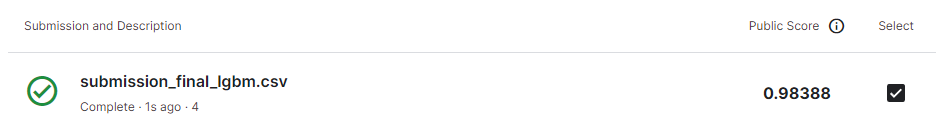

0.98388의 rmse값이 나왔습니다.

검증데이터 보다 테스트 데이터의 값이 더 낮게 나왔습니다.

과소적합 문제가 발생했습니다.

## 변수 선택

In [ ]:
# Modelling 클래스에서 lgbmr() 함수에 있는 코드를 가져와서 구현
# 위의 train_X, train_y, test_X 사용
model = LGBMRegressor()

model.fit(train_X, train_y)
y_pred = model.predict(test_X)
y_pred

array([0.62215547, 0.16957849, 1.1592912 , ..., 0.04725093, 0.0228968 ,
       0.03478677])

In [ ]:
# feature importance를 확인해보겠습니다.
feature_ = pd.DataFrame(model.feature_importances_, index = test_X.columns)
feature_

,0
date_block_num,77
shop_id,64
item_id,133
city_num,1
item_category_id,129
type_num,0
sub_type_num,62
item_cnt_month_lag_1,176
item_cnt_month_lag_2,84
item_cnt_month_lag_3,62


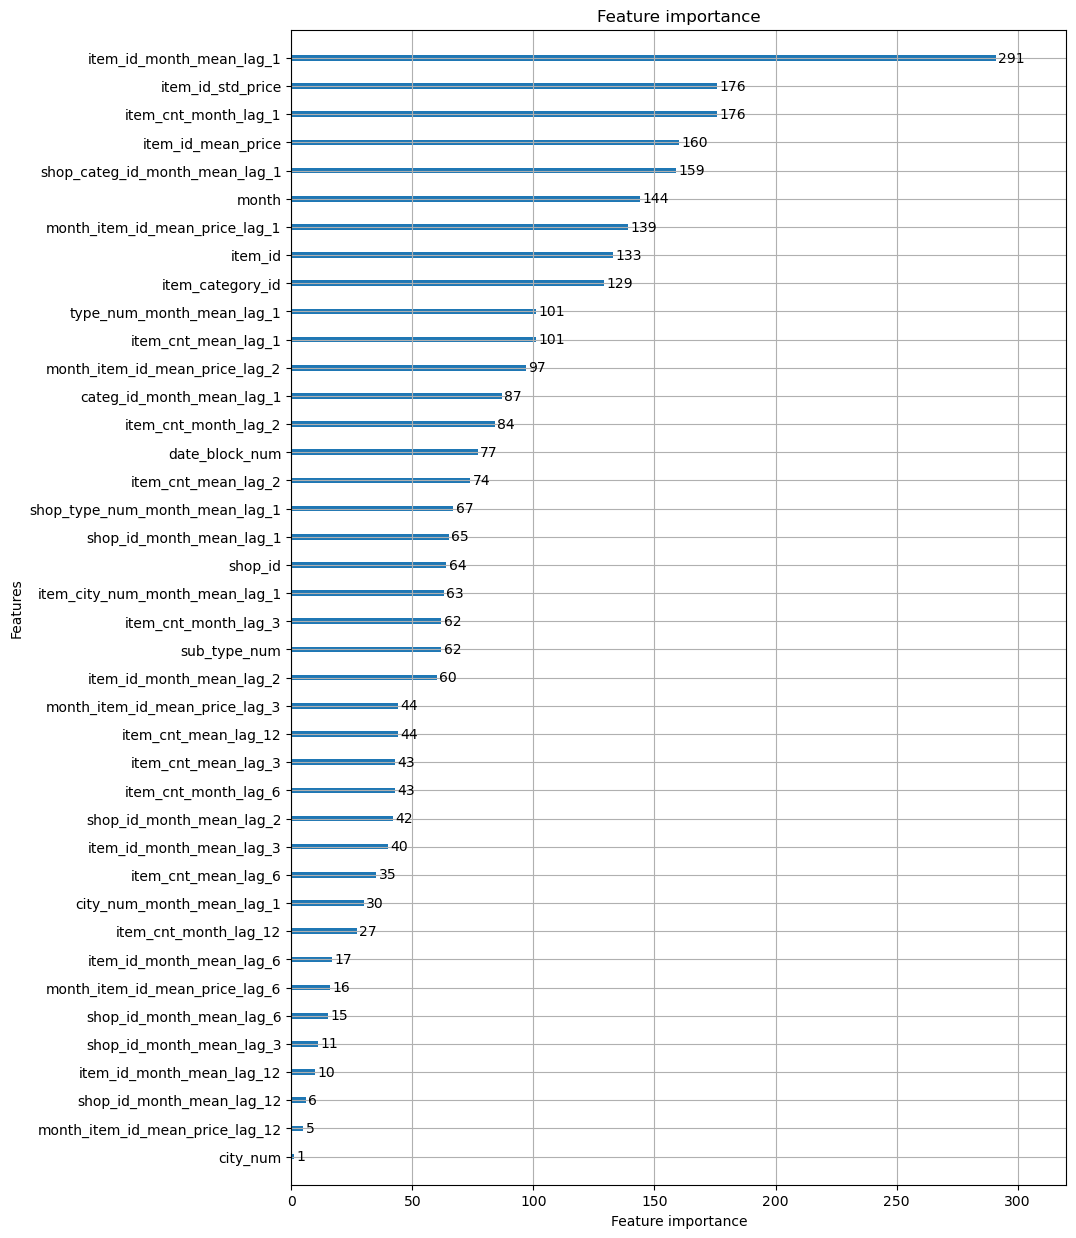

In [ ]:
# feature importance 시각화
fig, ax = plt.subplots(figsize = (10,15))
plot_importance(model, ax =ax)
plt.show()


In [ ]:
# 시각화 하면서 0인값은 나타나지 않았습니다.
# 내림차순 정렬로 하여 0인값 확인해보겠습니다.
feature_ = feature_.sort_values(0, ascending= False)
feature_

,0
item_id_month_mean_lag_1,291
item_id_std_price,176
item_cnt_month_lag_1,176
item_id_mean_price,160
shop_categ_id_month_mean_lag_1,159
month,144
month_item_id_mean_price_lag_1,139
item_id,133
item_category_id,129
type_num_month_mean_lag_1,101


In [ ]:
# feature importance 가 0보다 작은 값을 제외하고 다시 모델링을 해보겠습니다.

feature_ = feature_[feature_[0] > 0]
col = feature_.index

In [ ]:
col

Index(['item_id_month_mean_lag_1', 'item_id_std_price', 'item_cnt_month_lag_1',
       'item_id_mean_price', 'shop_categ_id_month_mean_lag_1', 'month',
       'month_item_id_mean_price_lag_1', 'item_id', 'item_category_id',
       'type_num_month_mean_lag_1', 'item_cnt_mean_lag_1',
       'month_item_id_mean_price_lag_2', 'categ_id_month_mean_lag_1',
       'item_cnt_month_lag_2', 'date_block_num', 'item_cnt_mean_lag_2',
       'shop_type_num_month_mean_lag_1', 'shop_id_month_mean_lag_1', 'shop_id',
       'item_city_num_month_mean_lag_1', 'sub_type_num',
       'item_cnt_month_lag_3', 'item_id_month_mean_lag_2',
       'item_cnt_mean_lag_12', 'month_item_id_mean_price_lag_3',
       'item_cnt_mean_lag_3', 'item_cnt_month_lag_6',
       'shop_id_month_mean_lag_2', 'item_id_month_mean_lag_3',
       'item_cnt_mean_lag_6', 'city_num_month_mean_lag_1',
       'item_cnt_month_lag_12', 'item_id_month_mean_lag_6',
       'month_item_id_mean_price_lag_6', 'shop_id_month_mean_lag_6',
       's

In [ ]:
# validation 검증 데이터와 train데이터  test데이터 분리
train = final_matrix[final_matrix['date_block_num'] < 33]
val = final_matrix[final_matrix['date_block_num'] == 33]
test = final_matrix[final_matrix['date_block_num'] == 34]

In [ ]:
# train과 val, test에 사용할 컬럼 뽑아내기

train_X = train[col]
train_y = train['item_cnt_month']
val_X = val[col]
val_y = val['item_cnt_month']

test_X = test[col]

In [ ]:
# 변수제거를 하여 검증데이터로 모델링
model = LGBMRegressor()
model.fit(train_X, train_y)
y_pred = model.predict(val_X)
rmse = np.sqrt(mean_squared_error(val_y, y_pred.clip(0,20)))
print('rmse :', rmse)

rmse : 1.068008973706724


검증데이터의 rmse가 살짝 줄어들었습니다.
이제 test데이터로 확인을 해보겠습니다.

In [ ]:
# test 데이터 모델링

model = LGBMRegressor()
model.fit(train_X, train_y)
y_pred = model.predict(test_X)
y_pred

array([0.62215547, 0.16957849, 1.1592912 , ..., 0.04725093, 0.0228968 ,
       0.03478677])

In [ ]:
subm_lgbm['item_cnt_month'] = y_pred.clip(0,20)
subm_lgbm

,ID,item_cnt_month
0,0,0.622155
1,1,0.169578
2,2,1.159291
3,3,0.794993
4,4,1.427998
...,...,...
214195,214195,0.099308
214196,214196,0.043382
214197,214197,0.047251
214198,214198,0.022897


In [ ]:
# subm_lgbm.to_csv('./submission_final_lgbm_feature.csv', index = False)

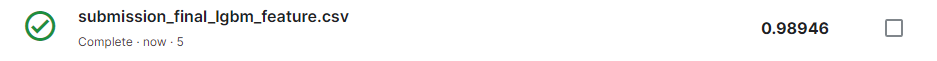

test 데이터의 rmse는 조금 올랐습니다.

여전히 과소적합 문제가 있습니다.

In [ ]:
# feature importance 확인
model.feature_importances_

array([308, 187, 176, 159, 159, 165, 140, 128, 125, 104,  78,  98,  86,
        84,  66,  73,  67,  64,  64,  63,  60,  62,  59,  42,  44,  43,
        43,  42,  39,  35,  30,  27,  17,  16,  14,  11,  10,   6,   5,
         1])

In [ ]:
feature_ = pd.DataFrame(model.feature_importances_, index = test_X.columns)
feature_

,0
item_id_month_mean_lag_1,308
item_id_std_price,187
item_cnt_month_lag_1,176
item_id_mean_price,159
shop_categ_id_month_mean_lag_1,159
month,165
month_item_id_mean_price_lag_1,140
item_id,128
item_category_id,125
type_num_month_mean_lag_1,104


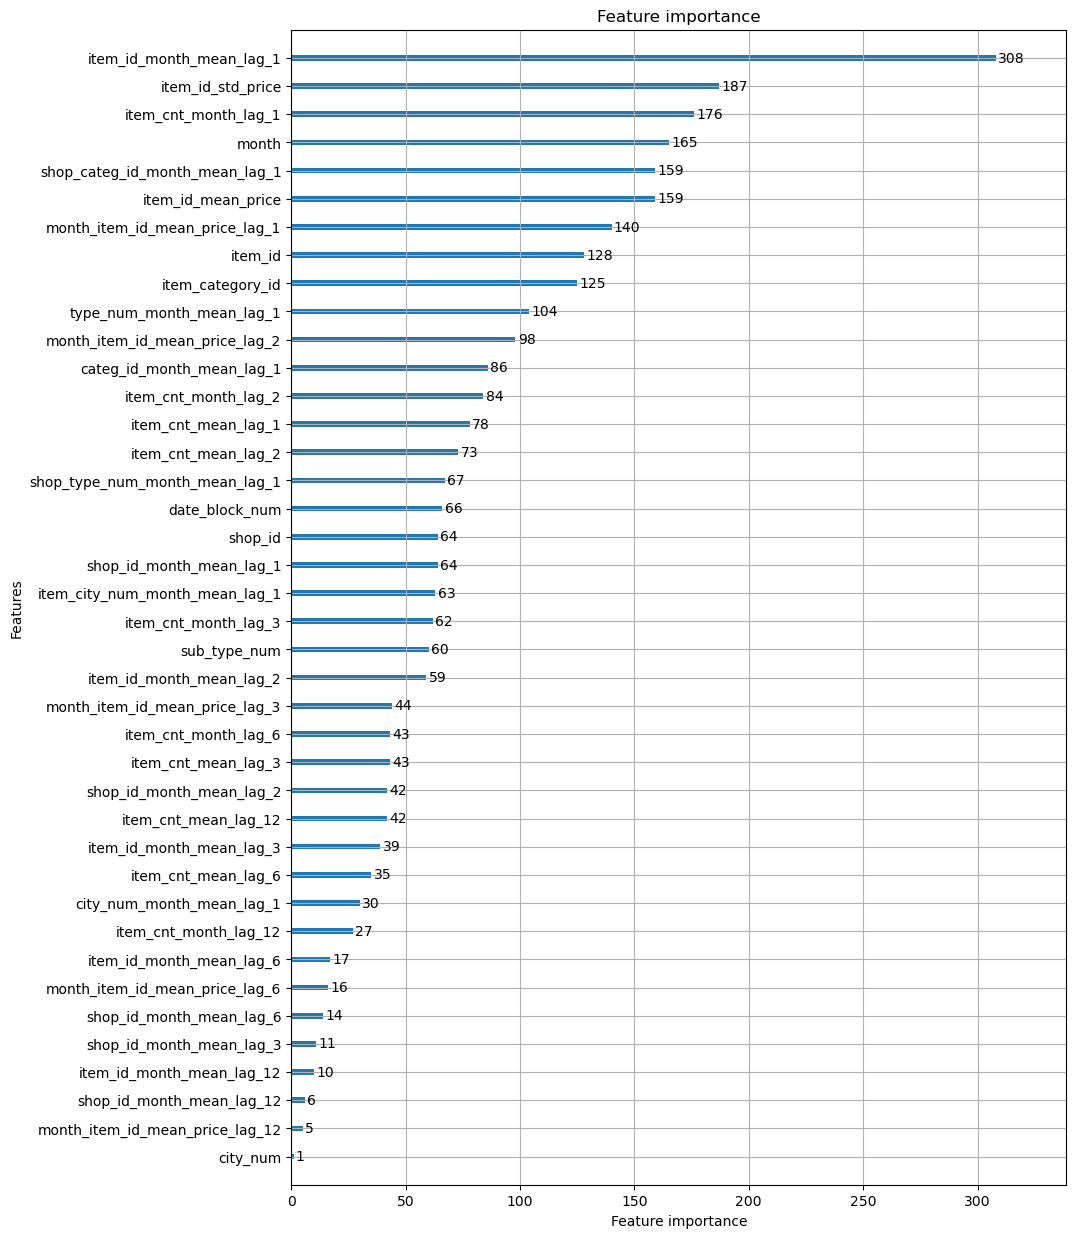

In [ ]:
# feature importance 시각화
fig, ax = plt.subplots(figsize = (10,15))
plot_importance(model, ax =ax)
plt.show()

In [ ]:
# feature importance가 50미만인 것을 제외하고 모델을 돌려보겠습니다.

feature_ = feature_.sort_values(0, ascending=False)
feature_ = feature_[feature_[0] >= 50]

In [ ]:
feature_

,0
item_id_month_mean_lag_1,308
item_id_std_price,187
item_cnt_month_lag_1,176
month,165
item_id_mean_price,159
shop_categ_id_month_mean_lag_1,159
month_item_id_mean_price_lag_1,140
item_id,128
item_category_id,125
type_num_month_mean_lag_1,104


In [ ]:
col = feature_.index
col

Index(['item_id_month_mean_lag_1', 'item_id_std_price', 'item_cnt_month_lag_1',
       'month', 'item_id_mean_price', 'shop_categ_id_month_mean_lag_1',
       'month_item_id_mean_price_lag_1', 'item_id', 'item_category_id',
       'type_num_month_mean_lag_1', 'month_item_id_mean_price_lag_2',
       'categ_id_month_mean_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_mean_lag_1', 'item_cnt_mean_lag_2',
       'shop_type_num_month_mean_lag_1', 'date_block_num',
       'shop_id_month_mean_lag_1', 'shop_id', 'item_city_num_month_mean_lag_1',
       'item_cnt_month_lag_3', 'sub_type_num', 'item_id_month_mean_lag_2'],
      dtype='object')

In [ ]:
# validation 검증 데이터와 train데이터 분리
train = final_matrix[final_matrix['date_block_num'] < 33]
val = final_matrix[final_matrix['date_block_num'] == 33]

# train data / val data X, y 값 분리
train_X = train[col]
train_y = train['item_cnt_month']
val_X = val[col]
val_y = val['item_cnt_month']

# 모델링
model = LGBMRegressor()
model.fit(train_X, train_y)
y_pred = model.predict(val_X)
rmse = np.sqrt(mean_squared_error(val_y, y_pred.clip(0,20)))
print('rmse :', rmse)

rmse : 1.0942079118492354


변수를 많이 빼니 모델의 설명력이 점점 나빠지고있다. 

처음부터 과소적합 문제가 발견되었고 변수를 줄이니 과소적합이 점점 심해졌다.

가장 좋았던 모든 feature를 가지고 최적화를 진행하겠습니다.
  - 과소 적합 문제가 있으므로 변수를 많이 추가하여 variance를 높여 함

## 모델 최적화

In [ ]:
col = ['date_block_num','shop_id', 'item_id','city_num', 'item_category_id', 'type_num', 'sub_type_num',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12', 'item_cnt_mean_lag_1',
       'item_cnt_mean_lag_2', 'item_cnt_mean_lag_3', 'item_cnt_mean_lag_6',
       'item_cnt_mean_lag_12', 'item_id_month_mean_lag_1',
       'item_id_month_mean_lag_2', 'item_id_month_mean_lag_3',
       'item_id_month_mean_lag_6', 'item_id_month_mean_lag_12',
       'shop_id_month_mean_lag_1', 'shop_id_month_mean_lag_2',
       'shop_id_month_mean_lag_3', 'shop_id_month_mean_lag_6',
       'shop_id_month_mean_lag_12', 'shop_item_id_month_mean_lag_1',
       'shop_item_id_month_mean_lag_2', 'shop_item_id_month_mean_lag_3',
       'shop_item_id_month_mean_lag_6', 'shop_item_id_month_mean_lag_12',
       'categ_id_month_mean_lag_1', 'shop_categ_id_month_mean_lag_1',
       'shop_type_num_month_mean_lag_1', 'city_num_month_mean_lag_1',
       'item_city_num_month_mean_lag_1', 'type_num_month_mean_lag_1',
       'item_id_mean_price',
       'month_item_id_mean_price_lag_1', 'month_item_id_mean_price_lag_2',
       'month_item_id_mean_price_lag_3', 'month_item_id_mean_price_lag_6',
       'month_item_id_mean_price_lag_12', 'item_id_std_price', 'year',
       'month']

In [ ]:
# validation 검증 데이터와 train데이터 분리
train = final_matrix[final_matrix['date_block_num'] < 33]
val = final_matrix[final_matrix['date_block_num'] == 33]
test = final_matrix[final_matrix['date_block_num'] == 34]


# train data / val data X, y 값 분리
train_X = train[col]
train_y = train['item_cnt_month']
val_X = val[col]
val_y = val['item_cnt_month']
test_X = test[col]

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV

model = LGBMRegressor()

param_grid = {
    'max_depth' : [-1, 5, 6, 7], # tree의 최대 깊이
    'learning_rate': [0.1, 0.01], # 부스팅 스탭 반복할 때 학습률
    'lambda_l2' : [0, 0.1, 1], # L2 regulation
    'metric' : ['rmse'] # 평가지표 rmse
}

cv = KFold(n_splits=5, random_state=42, shuffle=True)

gcv = GridSearchCV(model, param_grid = param_grid, cv= cv, scoring='neg_root_mean_squared_error')
# scoring -rmse 


gcv.fit(train_X, train_y)
print('best param : ', gcv.best_params_)
print('best rmse : ', -gcv.best_score_ ) # -rmse 로 나오기때문에 -값을 붙여줬다.

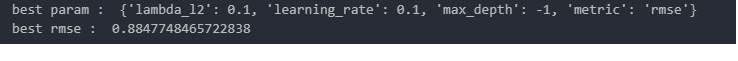

In [ ]:
y_pred = gcv.predict(val_X)

print('rmse :', np.sqrt(mean_squared_error(val_y, y_pred)))

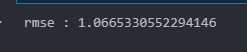

In [ ]:
# 훈련시킨 모델로 test데이터 예측하기

grid_pred = gcv.predict(test_X)
grid_pred

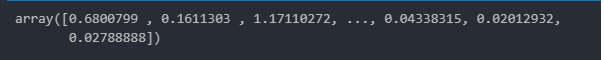

In [ ]:
submission = pd.read_csv('./sample_submission.csv')
submission['item_cnt_month'] = grid_pred.clip(0,20)
submission

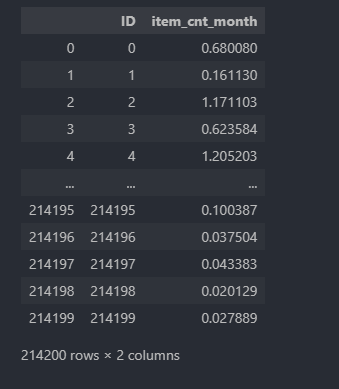

In [ ]:
submission.to_csv('./submission_final_grid_2.csv', index = False)

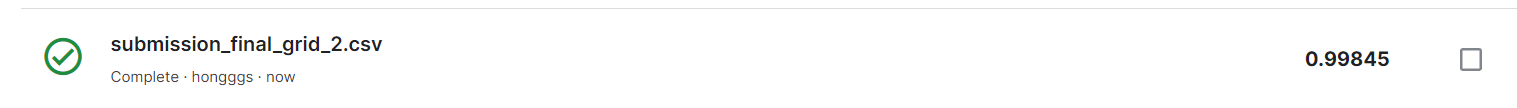

과소 적합 문제는 여전히 해결이 안됐습니다. 

파라미터 최적화를 진행 할 때 tree를 깊게 그려 과소적합 문제를 해결해 봐야겠습니다.

In [ ]:
# 오버피팅 규제 완화하여 모델 돌려보기
model = LGBMRegressor(n_estimators=300, # 부스트트리 갯수
                      num_leaves=50, # 최대 트리 리프
                      )

model.fit(train_X, train_y)
y_pred = model.predict(val_X)
print('rmse :', np.sqrt(mean_squared_error(val_y, y_pred)))


rmse : 1.0786352836561734


In [ ]:
lgbm_pred = model.predict(test_X)
lgbm_pred

array([0.74222974, 0.13949491, 1.34935418, ..., 0.05068332, 0.03896238,
       0.03578385])

In [ ]:
subm = pd.read_csv('./sample_submission.csv')
subm_lgbm = pd.read_csv('./sample_submission.csv')
subm_lgbm['item_cnt_month'] = lgbm_pred.clip(0,20)
subm_lgbm

,ID,item_cnt_month
0,0,0.742230
1,1,0.139495
2,2,1.349354
3,3,0.646839
4,4,0.182238
...,...,...
214195,214195,0.109401
214196,214196,0.040526
214197,214197,0.050683
214198,214198,0.038962


In [ ]:
# subm_lgbm.to_csv('./submission_final_over.csv', index = False)

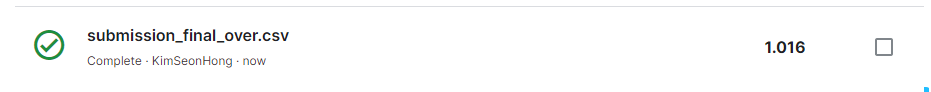

과소적합이 해결되고있지만 잘 예측을 하진 못한다.

1. 프로젝트의 한계점 고찰
        
        수요예측에 대한 지식이 부족했고 그에 따른 시계열 분석에 대한 지식을 더 쌓아야 되겠다고 느꼈다.
        수요예측에 대한 지식이 부족함에 따라 피쳐를 만드는데에 한계가 있었다.
        
        과소적합이 계속 일어나고 있다.
        과소적합을 해결하기 위해서는 variance를 높여주는 방향으로 전처리를 진행해야 한다.
        variance를 높이기 위해서는 변수를 더 추가해줘야 한다.
        현재에도 변수가 많은편이지만, 데이터의 양이 많고 변수의 질이 좋지 않은 것으로 판단된다.
        variance가 높은 모델로서는 Decision Tree, kNN, SVM 모델등이 있다.
        우리는 Decision Tree 계열 모델을 사용함으로 써 variance를 높여보았지만 원하는 만큼의 성과를 얻지 못했다.

2. 이번 프로젝트를 마치며

        김선홍 : lag데이터를 통해서 시계열 성을 부여하는 것을 알았고 쓸줄만 알았던 모델에 대해 팀원들에게 설명을 하기위해서 더 공부함으로써 모델들의 구조를 알게 되었던 프로젝트였습니다.

        윤희성 : 데이터 분석이 어떤 식으로 진행 되는지 알게 됐고 기계 학습에 대한 모델들에 대해 부족함을 느꼈고 더 공부해야겠다고 생각했습니다.

        오주화 : 데이터분석에 대한 전체적인 플로우를 알게 되었고, feature 설정에 대한 어려움을 느꼈습니다. 그래도 이번 프로젝트를 통해 그동안 배운 지식이 실무에서 어떤식으로 적용되는지 알 수 있어 좋았고, 팀원들과 고민해보고 의견을 나누는 시간들이 많이 즐거웠습니다. 

        정보석 : 어떤 특성 정보를 더해야하고 또 빼야하며 또 생각해내고 조절하는게 재밌으면서도 어려웠습니다. 머신러닝을 맛보기라도 경험한 것 같아 뿌듯합니다.

        홍수민 : 이번 프로젝트를 계기로 그동안 배운 지식을 활용할 수 있음에 즐거웠고 또 많이 배우게 되었습니다. 또한 모델링에 대한 중요성을 느꼈고 제가 많이 부족함을 느껴서 앞으로 더 열심히 배워야겠다는 생각을 했습니다. 하라쇼팀 짱!

        김민지 : 프로젝트를 진행하면서 부족했던 부분을 깨달았지만, 팀원들과 회의하며 채워나갈수있었습니다. 
        
